In [ ]:
!pip install sdv # install the synthetic data vault library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
from skimage.transform import resize
import pandas as pd
# import torch.nn.functional as F


import pandas as pd
import numpy as np
import math

# import scikit-learn preprocessing
from sklearn.preprocessing import LabelEncoder, QuantileTransformer,PowerTransformer

# import pytorch libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# import synthetic data value libraries
from sdv.metadata import SingleTableMetadata
import sdv.evaluation.single_table as sdv_st

# import utility libs
from tqdm import tqdm
import xlrd
import requests
from io import BytesIO
from zipfile import ZipFile
from datetime import datetime

# import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# set random seed
seed= 1234

# set dimension of categorical embedding
cat_emb_dim= 2

# set number of neurons per layes
mlp_layers=[1024,1024,1024,1024]

# set non-linear activation function
activation='lrelu'

# set number of diffusion steps
diffusion_steps= 1000

# set diffusion stop and end betas
diffusion_beta_start= 1e-4
diffusion_beta_end= 0.02

# set diffusion scheduler
scheduler= 'exp'

# set number of training epochs
epochs= 500

# set the training batch size
batch_size= 512

# set the training learning rate
learning_rate= 1e-4

# set the device
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu").type

beta_start=1e-4
beta_end=0.02

# set numpy seed
np.random.seed(seed)

# set pytorch seed
torch.manual_seed(seed)

# set cuda seed
torch.cuda.manual_seed(seed)

## Data prepration

In [ ]:
# define a preproces data function


from datetime import datetime
import calendar
import numpy as np
import pandas as pd
import random
import os
import numpy as np
import tensorflow as tf

# Set seeds
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)
os.environ['TF_DETERMINISTIC_OPS'] = '1'


def preprocess_data_czech(df):
    #df = pd.read_csv('tr_by_acct_w_age.csv')

    czech_date_parser = lambda x: datetime.strptime(str(x), "%y%m%d")
    df["datetime"] = df["date"].apply(czech_date_parser)
    #df["datetime"] = pd.to_datetime(df["datetime"])

    df["month"] = df["datetime"].dt.month
    df["day"] = df["datetime"].dt.day
    df["dow"] =  df["datetime"].dt.dayofweek
    df["year"] = df["datetime"].dt.year
    df["doy"] = df["datetime"].dt.dayofyear

    df["td"] = df[["account_id", "datetime"]].groupby("account_id").diff()
    df["td"] = df["td"].apply(lambda x: x.days)
    df["td"].fillna(0.0, inplace=True)


    # dtme - days till month end
    df["dtme"] = df.datetime.apply(lambda dt: calendar.monthrange(dt.year, dt.month)[1] - dt.day)

    df['raw_amount'] = df.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)


    cat_code_fields = ['type', 'operation', 'k_symbol']
    TCODE_SEP = "__"
    # create tcode by concating fields in "cat_code_fields"
    tcode = df[cat_code_fields[0]].astype(str)
    for ccf in cat_code_fields[1:]:
        tcode += TCODE_SEP + df[ccf].astype(str)

    df["tcode"] = tcode

    conditions = [
    (df['day'] >= 1) & (df['day'] <= 10),
    (df['day'] > 10) & (df['day'] <= 20),
    (df['day'] > 20) & (df['day'] <= 31)
      ]

    categories = ['first', 'middle', 'last']

    # Use numpy.select() to map the numbers to categories
    df['DoM_cat'] = np.select(conditions, categories, default='unknown')


    bin_edges = [17, 30, 40, 50, 60, 81]
    labels = ['18-30', '31-40', '41-50', '51-60', '61+']

    # Use pd.cut() to convert ages to categorical groups
    df['age_group'] = pd.cut(df['age'], bins=bin_edges, labels=labels, right=False)
    df['age_group'] = df['age_group'].astype('object')

    result = df.groupby('account_id')['datetime'].agg(['min', 'max'])
    result['duration'] = result['max'] - result['min']
    result_sorted = result.sort_values('duration', ascending=False)

    df['log_amount'] = np.log10(df['amount'] + 1)
    LOG_AMOUNT_SCALE = df['log_amount'].std()
    df['log_amount_sc'] = df['log_amount']/ LOG_AMOUNT_SCALE
    TD_SCALE = df['td'].std()
    df['td_sc'] = df['td']/TD_SCALE

    return df, LOG_AMOUNT_SCALE , TD_SCALE

In [ ]:
real = pd.read_csv('tr_by_acct_w_age.csv')
real = real.sort_values(by = ["account_id", "date"])
raw_data, LOG_AMOUNT_SCALE, TD_SCALE = preprocess_data_czech(real)



all_real = raw_data[['account_id', 'tcode', 'datetime', 'amount', 'td', 'day', 'month', 'year']]
all_real['type'] = all_real['tcode'].str.split('__').str[0]
all_real['raw_amount'] = all_real.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)
all_real_cf = all_real[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

/tmp/ipython-input-4-3939612794.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["td"].fillna(0.0, inplace=True)


## Model

In [ ]:
import numpy as np
from sklearn.preprocessing import (
    MinMaxScaler, StandardScaler, RobustScaler,
    QuantileTransformer, PowerTransformer,
    PolynomialFeatures, KBinsDiscretizer, SplineTransformer
)
from scipy import stats

In [ ]:
class RobustQuantileTransformer:
    """Combined robust and quantile transformation"""

    def __init__(self, quantile_range=(5, 95), output_distribution='normal'):
        self.quantile_range = quantile_range
        self.output_distribution = output_distribution
        self.robust_scaler = RobustScaler(quantile_range=quantile_range)
        self.quantile_transformer = QuantileTransformer(
            output_distribution=output_distribution,
            random_state=42
        )

    def fit(self, X):
        # First apply robust scaling to handle outliers
        X_robust = self.robust_scaler.fit_transform(X)
        # Then apply quantile transformation
        self.quantile_transformer.fit(X_robust)
        return self

    def transform(self, X):
        X_robust = self.robust_scaler.transform(X)
        return self.quantile_transformer.transform(X_robust)

    def inverse_transform(self, X):
        X_inv_quantile = self.quantile_transformer.inverse_transform(X)
        return self.robust_scaler.inverse_transform(X_inv_quantile)

In [ ]:
from scipy.stats import norm, rankdata
import numpy as np

class CustomQuantileGaussianTransformer:
    def fit(self, X):
        X = np.asarray(X)
        self.n_samples_, self.n_features_ = X.shape
        self.sorted_X_ = []
        for i in range(self.n_features_):
            col = X[:, i]
            self.sorted_X_.append(np.sort(col))
        return self

    def transform(self, X):
        X = np.asarray(X)
        X_out = np.zeros_like(X, dtype=float)
        for i in range(X.shape[1]):
            ranks = rankdata(X[:, i], method='average') / (len(X[:, i]) + 1)
            X_out[:, i] = norm.ppf(ranks)
        return X_out

    def inverse_transform(self, X_transformed):
        X_transformed = np.asarray(X_transformed)
        X_out = np.zeros_like(X_transformed, dtype=float)
        for i in range(X_transformed.shape[1]):
            uniform_vals = norm.cdf(X_transformed[:, i])
            percentiles = np.linspace(0, 1, self.n_samples_, endpoint=False) + 0.5 / self.n_samples_
            X_out[:, i] = np.interp(uniform_vals, percentiles, self.sorted_X_[i])
        return X_out


In [ ]:
# @title Default title text
# This version also act good

# seed = 1234
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Model hyperparameters
# sequence_length = 80
# min_seq_length = 80
# cat_emb_dim = 4
# mlp_layers = [128, 128]
# diffusion_steps = 500  # Reduced for efficiency
# epochs = 50  # Reduced for efficiency
# batch_size = 256
# learning_rate = 2e-4
# n_sequences = 5000

# # Date constraints
# MIN_YEAR = 1993
# MAX_YEAR = 1998

# {'jsd': 0.17666379079128386,
#  'entr_r': np.float64(4.142583700511794),
#  'entr_g': np.float64(4.998523941057718),
#  'NED': np.float64(-0.855940240545924),
#  'l1': np.float64(0.9483875141141689),
#  'l2': 0.12218879424693639,
#  'jac': np.float64(0.06481481481481481),
#  'count_r': 202,
#  'coverage_r': 0.9351851851851852,
#  'count_g': 216,
#  'coverage_g': 1.0,
#  'count_max': 216,
#  'field': 'tcode',
#  'n': 3,
#  'pseudo_counts': 0.0}


# {'amount': {'wasser': np.float64(682.1070215071861),
#   'ks': np.float64(0.140266349591033),
#   'energy_d': np.float64(9.15508966232386)},
#  'td': {'wasser': np.float64(0.48902485913359595),
#   'ks': np.float64(0.11245570205998183),
#   'energy_d': np.float64(0.19747738204716697)},
#  'CF': {'wasser': np.float64(13021.12391497244),
#   'ks': np.float64(0.32986821530718735),
#   'energy_d': np.float64(67.69154098302828)}}


#   {'tcode': 0.03598723757365223,
#  'day': 0.0644653630179872,
#  'month': 0.011520275842911602}



# the best parame is the following one:

# seed = 1234
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Model hyperparameters
# sequence_length = 80
# min_seq_length = 20
# cat_emb_dim = 4
# mlp_layers = [128, 128]
# diffusion_steps = 1000  # Reduced for efficiency
# epochs = 50  # Reduced for efficiency
# batch_size = 256
# learning_rate = 2e-4
# n_sequences = 5000

# # Date constraints
# MIN_YEAR = 1993
# MAX_YEAR = 1998

# last updated best params:

# seed = 1234
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Model hyperparameters
# sequence_length = 80
# min_seq_length = 20
# cat_emb_dim = 4
# mlp_layers = [128, 128]
# diffusion_steps = 1000  # Reduced for efficiency
# epochs = 50  # Reduced for efficiency
# batch_size = 512
# learning_rate = 2e-4
# n_sequences = 5000

# # Date constraints
# MIN_YEAR = 1993
# MAX_YEAR = 1998


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import LabelEncoder, QuantileTransformer,FunctionTransformer


import pandas as pd
import numpy as np
import math
import random
import os
from datetime import datetime, timedelta
import calendar
from tqdm import tqdm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Quality evaluation imports
from sdv.metadata import SingleTableMetadata
from sdv import evaluation

# =============================================================================
# CONFIGURATION
# =============================================================================
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model hyperparameters
sequence_length = 80
min_seq_length = 20
cat_emb_dim = 4
mlp_layers = [128, 128]
diffusion_steps = 1000  # Reduced for efficiency
epochs = 50  # Reduced for efficiency
batch_size = 512
learning_rate = 2e-4
n_sequences = 5000

# Date constraints
# MIN_YEAR = 1993
# MAX_YEAR = 1998
# =============================================================================
# STUDENT-T DISTRIBUTION DDPM DIFFUSER (Condensed)
# =============================================================================
class StudentTDDPMDiffuser(object):
    def __init__(self, total_steps=1000, beta_start=1e-4, beta_end=0.02, device='cpu', df=10):
        self.total_steps = total_steps
        self.device = device
        self.df = df

        # Exponential schedule
        scale = 1000 / total_steps
        betas = torch.exp(torch.linspace(math.log(scale * beta_start),
                                        math.log(scale * beta_end), total_steps))
        self.alphas = (1.0 - betas).to(device)
        self.betas = betas.to(device)
        self.alphas_hat = torch.cumprod(self.alphas, dim=0)

    def sample_random_timesteps(self, n: int):
        return torch.randint(low=1, high=self.total_steps, size=(n,), device=self.device)

    def sample_student_t(self, shape):
        x = torch.randn(shape, device=self.device)
        df_sample = max(3.0, float(self.df))
        gamma_shape = df_sample / 2.0
        gamma_samples = torch.tensor(stats.gamma.rvs(gamma_shape, scale=2.0, size=shape[0]),
                                   dtype=torch.float32, device=self.device).view(-1, 1, 1)
        scaling = torch.sqrt(torch.tensor(df_sample / (df_sample - 2.0), device=self.device))
        return scaling * x / torch.sqrt(gamma_samples / df_sample)

    def add_t_noise(self, x_num, t):
        sqrt_alpha_hat = torch.sqrt(self.alphas_hat[t])[:, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alphas_hat[t])[:, None, None]
        noise_num = self.sample_student_t(x_num.shape)
        return sqrt_alpha_hat * x_num + sqrt_one_minus_alpha_hat * noise_num, noise_num

    def sample(self, model_out, z_norm, timesteps):
        sqrt_alpha_t = torch.sqrt(self.alphas[timesteps])[:, None, None]
        betas_t = self.betas[timesteps][:, None, None]
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - self.alphas_hat[timesteps])[:, None, None]
        epsilon_t = torch.sqrt(self.betas[timesteps][:, None, None])

        random_noise = self.sample_student_t(z_norm.shape)
        random_noise[timesteps == 0] = 0.0

        model_mean = ((1 / sqrt_alpha_t) * (z_norm - (betas_t * model_out / sqrt_one_minus_alpha_hat_t)))
        return model_mean + (epsilon_t * random_noise)

# =============================================================================
# DATA PREPROCESSING (Streamlined)
# =============================================================================
# def preprocess_data_czech(df):
#     czech_date_parser = lambda x: datetime.strptime(str(x), "%y%m%d")
#     df["datetime"] = df["date"].apply(czech_date_parser)
#     df["month"] = df["datetime"].dt.month
#     df["day"] = df["datetime"].dt.day
#     df["dow"] = df["datetime"].dt.dayofweek
#     df["year"] = df["datetime"].dt.year

#     df_sorted = df.sort_values(['account_id', 'datetime']).copy()
#     df_sorted["td"] = df_sorted.groupby("account_id")["datetime"].diff().dt.days.fillna(0.0)
#     df_sorted['raw_amount'] = df_sorted.apply(
#         lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

#     # Simplified transaction code
#     df_sorted["tcode"] = df_sorted['type'].astype(str) + "__" + df_sorted['operation'].astype(str)

#     # Day categories
#     conditions = [(df_sorted['day'] <= 10), (df_sorted['day'] <= 20)]
#     categories = ['first', 'middle', 'last']
#     df_sorted['DoM_cat'] = np.select(conditions, categories[:2], default='last')

#     return df_sorted

# define a preproces data function


from datetime import datetime
import calendar
import numpy as np
import pandas as pd
import random
import os
import numpy as np
import tensorflow as tf

# Set seeds
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)
os.environ['TF_DETERMINISTIC_OPS'] = '1'


def preprocess_data_czech(df):
    #df = pd.read_csv('tr_by_acct_w_age.csv')

    czech_date_parser = lambda x: datetime.strptime(str(x), "%y%m%d")
    df["datetime"] = df["date"].apply(czech_date_parser)
    #df["datetime"] = pd.to_datetime(df["datetime"])

    df["month"] = df["datetime"].dt.month
    df["day"] = df["datetime"].dt.day
    df["dow"] =  df["datetime"].dt.dayofweek
    df["year"] = df["datetime"].dt.year
    df["doy"] = df["datetime"].dt.dayofyear

    df["td"] = df[["account_id", "datetime"]].groupby("account_id").diff()
    df["td"] = df["td"].apply(lambda x: x.days)
    df["td"].fillna(0.0, inplace=True)


    # dtme - days till month end
    df["dtme"] = df.datetime.apply(lambda dt: calendar.monthrange(dt.year, dt.month)[1] - dt.day)

    df['raw_amount'] = df.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)


    cat_code_fields = ['type', 'operation', 'k_symbol']
    TCODE_SEP = "__"
    # create tcode by concating fields in "cat_code_fields"
    tcode = df[cat_code_fields[0]].astype(str)
    for ccf in cat_code_fields[1:]:
        tcode += TCODE_SEP + df[ccf].astype(str)

    df["tcode"] = tcode

    conditions = [
    (df['day'] >= 1) & (df['day'] <= 10),
    (df['day'] > 10) & (df['day'] <= 20),
    (df['day'] > 20) & (df['day'] <= 31)
      ]

    categories = ['first', 'middle', 'last']

    # Use numpy.select() to map the numbers to categories
    df['DoM_cat'] = np.select(conditions, categories, default='unknown')


    bin_edges = [17, 30, 40, 50, 60, 81]
    labels = ['18-30', '31-40', '41-50', '51-60', '61+']

    # Use pd.cut() to convert ages to categorical groups
    df['age_group'] = pd.cut(df['age'], bins=bin_edges, labels=labels, right=False)
    df['age_group'] = df['age_group'].astype('object')

    result = df.groupby('account_id')['datetime'].agg(['min', 'max'])
    result['duration'] = result['max'] - result['min']
    result_sorted = result.sort_values('duration', ascending=False)

    df['log_amount'] = np.log10(df['amount'] + 1)
    LOG_AMOUNT_SCALE = df['log_amount'].std()
    df['log_amount_sc'] = df['log_amount']/ LOG_AMOUNT_SCALE
    TD_SCALE = df['td'].std()
    df['td_sc'] = df['td']/TD_SCALE
    df_sorted=df

    return df_sorted

# =============================================================================
# DATASET (Simplified)
# =============================================================================
class TemporalSequentialDataset(Dataset):
    def __init__(self, df, cat_attrs, num_attrs, sequence_length=30, min_seq_length=20):
        self.sequences = []
        for account_id in tqdm(df['account_id'].unique(), desc="Creating sequences"):
            account_data = df[df['account_id'] == account_id].sort_values('datetime').reset_index(drop=True)
            if len(account_data) >= min_seq_length:
                for start_idx in range(0, len(account_data) - sequence_length + 1, sequence_length//2):
                    seq_data = account_data.iloc[start_idx:start_idx+sequence_length]
                    self.sequences.append({
                        'cat_data': seq_data[cat_attrs].values,
                        'num_data': seq_data[num_attrs].values
                    })

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        return torch.LongTensor(seq['cat_data']), torch.FloatTensor(seq['num_data'])

# =============================================================================
# MODEL (Condensed)
# =============================================================================
class TemporalLSTMSynthesizer(nn.Module):
    def __init__(self, n_cat_features, n_cat_tokens, cat_emb_dim, n_num_features, hidden_dim=128):
        super().__init__()
        self.n_cat_features = n_cat_features
        self.n_num_features = n_num_features

        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(n_cat_tokens[i], cat_emb_dim) for i in range(n_cat_features)
        ])

        total_input_dim = n_cat_features * cat_emb_dim + n_num_features

        self.time_embed = nn.Sequential(
            nn.Linear(64, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, hidden_dim)
        )
        self.input_projection = nn.Linear(total_input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, 2, batch_first=True, dropout=0.1)

        self.cat_heads = nn.ModuleList([
            nn.Linear(hidden_dim, n_cat_tokens[i]) for i in range(n_cat_features)
        ])
        self.num_head = nn.Linear(hidden_dim, n_num_features)

    def embed_time(self, timesteps, dim_out=64):
        half = dim_out // 2
        freqs = torch.exp(-math.log(1000) * torch.arange(0, half, dtype=torch.float32) / half).to(timesteps.device)
        args = timesteps[:, None].float() * freqs[None]
        return torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

    def forward(self, x_cat, x_num, timesteps):
        batch_size, seq_len, _ = x_num.shape

        # Embed categorical
        cat_emb = torch.cat([self.cat_embeddings[i](x_cat[:, :, i])
                           for i in range(self.n_cat_features)], dim=-1)

        # Combine features
        x = torch.cat([cat_emb, x_num], dim=-1)
        x_proj = self.input_projection(x)

        # Add time embedding
        time_emb = self.time_embed(self.embed_time(timesteps))
        x_with_time = x_proj + time_emb.unsqueeze(1).expand(-1, seq_len, -1)

        # LSTM processing
        lstm_out, _ = self.lstm(x_with_time)

        # Generate outputs
        cat_outputs = [head(lstm_out) for head in self.cat_heads]
        num_output = self.num_head(lstm_out)

        return cat_outputs, num_output

# =============================================================================
# TRAINING (Streamlined)
# =============================================================================
def train_model(model, diffuser, dataloader, epochs, optimizer, scheduler):
    model.train()
    cat_criterion = nn.CrossEntropyLoss()
    num_criterion = nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_cat, batch_num in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
            batch_cat, batch_num = batch_cat.to(device), batch_num.to(device)
            timesteps = diffuser.sample_random_timesteps(batch_cat.shape[0])
            noisy_num, noise_target = diffuser.add_t_noise(batch_num, timesteps)

            cat_outputs, num_output = model(batch_cat, noisy_num, timesteps)

            cat_loss = sum(cat_criterion(cat_out.view(-1, cat_out.size(-1)),
                                       batch_cat[:, :, i].view(-1))
                          for i, cat_out in enumerate(cat_outputs))
            num_loss = num_criterion(num_output, noise_target)
            total_loss = cat_loss + num_loss

            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_loss += total_loss.item()

        print(f"Epoch {epoch+1} - Loss: {epoch_loss/len(dataloader):.4f}")
        scheduler.step()

# =============================================================================
# GENERATION WITH DATE CONSTRAINTS
# =============================================================================
def generate_sequences(model, diffuser, n_sequences, seq_len, n_cat_features, n_cat_tokens, n_num_features):
    model.eval()

    x_cat = torch.zeros(n_sequences, seq_len, n_cat_features, dtype=torch.long, device=device)
    for i, n_tokens in enumerate(n_cat_tokens):
        x_cat[:, :, i] = torch.randint(0, n_tokens, (n_sequences, seq_len), device=device)

    x_num = diffuser.sample_student_t((n_sequences, seq_len, n_num_features))

    with torch.no_grad():
        for t in tqdm(reversed(range(diffuser.total_steps)), desc="Generating"):
            timesteps = torch.full((n_sequences,), t, device=device, dtype=torch.long)
            cat_outputs, num_output = model(x_cat, x_num, timesteps)
            x_num = diffuser.sample(num_output, x_num, timesteps)

            if t % 100 == 0:
                for i, cat_out in enumerate(cat_outputs):
                    probs = torch.softmax(cat_out, dim=-1)
                    x_cat[:, :, i] = torch.multinomial(probs.view(-1, probs.size(-1)), 1).view(n_sequences, seq_len)

    return x_cat, x_num

def create_dataframe_with_date_constraints(generated_cat, generated_num, cat_attrs, num_attrs,
                                         label_encoders, num_scaler):
    """Create dataframe with dates constrained to 1993-1998"""
    final_sequences = []

    for seq_idx in range(generated_cat.shape[0]):
        seq_num = num_scaler.inverse_transform(generated_num[seq_idx].cpu().numpy())
        seq_cat = generated_cat[seq_idx].cpu().numpy()

        seq_df = pd.DataFrame()

        # Add numerical features
        for i, col in enumerate(num_attrs):
            seq_df[col] = seq_num[:, i]

        # Add categorical features
        for i, col in enumerate(cat_attrs):
            seq_df[col] = label_encoders[col].inverse_transform(seq_cat[:, i])

        # seq_df['datetime'] = dates
        seq_df['account_id'] = seq_idx + 1000  # Start from 1000 to avoid conflicts

        final_sequences.append(seq_df)

    return pd.concat(final_sequences, ignore_index=True)

# =============================================================================
# MAIN EXECUTION
# =============================================================================
if __name__ == "__main__":
    print("Loading data...")
    try:
        real = pd.read_csv('tr_by_acct_w_age.csv')
    except FileNotFoundError:
        print("Error: CSV file not found.")
        exit()

    # Preprocess
    raw_data = preprocess_data_czech(real)
    cat_attrs = ['tcode', 'dow', 'month', 'day', 'year', 'DoM_cat']
    num_attrs = ['amount', 'raw_amount', 'td']

    df_processed = raw_data[cat_attrs + num_attrs + ['account_id', 'datetime']].copy()

    # Encode features
    label_encoders = {}
    n_cat_tokens = []
    for attr in cat_attrs:
        le = LabelEncoder()
        df_processed[attr] = le.fit_transform(df_processed[attr].astype(str))
        label_encoders[attr] = le
        n_cat_tokens.append(len(le.classes_))

    num_scaler = QuantileTransformer(output_distribution='normal', random_state=seed)
    df_processed[num_attrs] = num_scaler.fit_transform(df_processed[num_attrs])

    # num_scaler = FunctionTransformer(func=np.cbrt)
    # df_processed[num_attrs] = num_scaler.fit_transform(df_processed[num_attrs])




    # num_scaler = CustomQuantileGaussianTransformer()
    # num_scaler.fit(df_processed[num_attrs])
    # df_processed[num_attrs] = num_scaler.transform(df_processed[num_attrs])

    # num_scaler = CustomQuantileGaussianTransformer()
    # num_scaler.fit(df_processed[num_attrs].values)

    # df_processed[num_attrs] = num_scaler.transform(df_processed[num_attrs].values)



    # num_scaler = MinMaxScaler()
    # df_processed[num_attrs] = num_scaler.fit_transform(df_processed[num_attrs])

    # num_scaler = StandardScaler()
    # df_processed[num_attrs] = num_scaler.fit_transform(df_processed[num_attrs])

    # num_scaler = RobustScaler()
    # df_processed[num_attrs] = num_scaler.fit_transform(df_processed[num_attrs])

    # num_scaler = PowerTransformer(method='yeo-johnson', standardize=True)
    # # X_pos = X + 1  # ensure all values are positive
    # df_processed[num_attrs] = num_scaler.fit_transform(df_processed[num_attrs])





    # Create dataset and model
    dataset = TemporalSequentialDataset(df_processed, cat_attrs, num_attrs, sequence_length, min_seq_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = TemporalLSTMSynthesizer(
        n_cat_features=len(cat_attrs), n_cat_tokens=n_cat_tokens,
        cat_emb_dim=cat_emb_dim, n_num_features=len(num_attrs)
    ).to(device)

    diffuser = StudentTDDPMDiffuser(device=device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    print(f"Training model with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters...")

    # Train
    train_model(model, diffuser, dataloader, epochs, optimizer, scheduler)

    # Generate with date constraints
    print("Generating sequences with 1993-1998 date constraints...")
    generated_cat, generated_num = generate_sequences(
        model, diffuser, n_sequences, sequence_length,
        len(cat_attrs), n_cat_tokens, len(num_attrs)
    )

    # Create final dataframe with date constraints
    synth_data = create_dataframe_with_date_constraints(
        generated_cat, generated_num, cat_attrs, num_attrs,
        label_encoders, num_scaler
    )

    # Prepare data for quality evaluation
    synth_sorted = synth_data[['account_id', 'raw_amount', 'amount', 'td', 'tcode', 'year','day','month']].copy()
    synth_sorted = synth_sorted.dropna()

    # Prepare real data for comparison (same columns)
    real_comparison = raw_data[['account_id', 'raw_amount', 'amount', 'td', 'tcode', 'year','day','month']].copy()
    real_comparison = real_comparison.dropna()

    print(f"\nGenerated data shape: {synth_sorted.shape}")
    # print(f"Date range: {synth_sorted['datetime'].min()} to {synth_sorted['datetime'].max()}")
    print("\nSample generated data:")
    print(synth_sorted.head(10))


    synth_sorted.to_csv('synthetic_transactions_1993_1998.csv', index=False)
    # print(f"\nSynthetic data saved! Dates constrained to {MIN_YEAR}-{MAX_YEAR}")




Loading data...


Creating sequences: 100%|██████████| 4500/4500 [00:25<00:00, 176.65it/s]


Training model with 302,970 parameters...


Epoch 1: 100%|██████████| 39/39 [00:02<00:00, 17.43it/s]


Epoch 1 - Loss: 14.6634


Epoch 2: 100%|██████████| 39/39 [00:02<00:00, 18.09it/s]


Epoch 2 - Loss: 13.1258


Epoch 3: 100%|██████████| 39/39 [00:02<00:00, 18.18it/s]


Epoch 3 - Loss: 12.0383


Epoch 4: 100%|██████████| 39/39 [00:02<00:00, 18.07it/s]


Epoch 4 - Loss: 11.1301


Epoch 5: 100%|██████████| 39/39 [00:02<00:00, 16.60it/s]


Epoch 5 - Loss: 10.1871


Epoch 6: 100%|██████████| 39/39 [00:02<00:00, 17.94it/s]


Epoch 6 - Loss: 9.2010


Epoch 7: 100%|██████████| 39/39 [00:02<00:00, 18.01it/s]


Epoch 7 - Loss: 8.3603


Epoch 8: 100%|██████████| 39/39 [00:02<00:00, 17.82it/s]


Epoch 8 - Loss: 7.6467


Epoch 9: 100%|██████████| 39/39 [00:02<00:00, 17.91it/s]


Epoch 9 - Loss: 7.0338


Epoch 10: 100%|██████████| 39/39 [00:02<00:00, 17.30it/s]


Epoch 10 - Loss: 6.4933


Epoch 11: 100%|██████████| 39/39 [00:02<00:00, 16.78it/s]


Epoch 11 - Loss: 6.0182


Epoch 12: 100%|██████████| 39/39 [00:02<00:00, 17.86it/s]


Epoch 12 - Loss: 5.6243


Epoch 13: 100%|██████████| 39/39 [00:02<00:00, 17.92it/s]


Epoch 13 - Loss: 5.2687


Epoch 14: 100%|██████████| 39/39 [00:02<00:00, 16.63it/s]


Epoch 14 - Loss: 4.9731


Epoch 15: 100%|██████████| 39/39 [00:02<00:00, 17.65it/s]


Epoch 15 - Loss: 4.6955


Epoch 16: 100%|██████████| 39/39 [00:02<00:00, 16.72it/s]


Epoch 16 - Loss: 4.4550


Epoch 17: 100%|██████████| 39/39 [00:02<00:00, 17.67it/s]


Epoch 17 - Loss: 4.2269


Epoch 18: 100%|██████████| 39/39 [00:02<00:00, 18.03it/s]


Epoch 18 - Loss: 4.0191


Epoch 19: 100%|██████████| 39/39 [00:02<00:00, 18.06it/s]


Epoch 19 - Loss: 3.8333


Epoch 20: 100%|██████████| 39/39 [00:02<00:00, 13.39it/s]


Epoch 20 - Loss: 3.6436


Epoch 21: 100%|██████████| 39/39 [00:02<00:00, 17.10it/s]


Epoch 21 - Loss: 3.4818


Epoch 22: 100%|██████████| 39/39 [00:02<00:00, 17.29it/s]


Epoch 22 - Loss: 3.3178


Epoch 23: 100%|██████████| 39/39 [00:02<00:00, 18.20it/s]


Epoch 23 - Loss: 3.1721


Epoch 24: 100%|██████████| 39/39 [00:02<00:00, 18.21it/s]


Epoch 24 - Loss: 3.0531


Epoch 25: 100%|██████████| 39/39 [00:02<00:00, 18.05it/s]


Epoch 25 - Loss: 2.9351


Epoch 26: 100%|██████████| 39/39 [00:02<00:00, 18.15it/s]


Epoch 26 - Loss: 2.8427


Epoch 27: 100%|██████████| 39/39 [00:02<00:00, 16.87it/s]


Epoch 27 - Loss: 2.7539


Epoch 28: 100%|██████████| 39/39 [00:02<00:00, 17.92it/s]


Epoch 28 - Loss: 2.6698


Epoch 29: 100%|██████████| 39/39 [00:02<00:00, 18.20it/s]


Epoch 29 - Loss: 2.6073


Epoch 30: 100%|██████████| 39/39 [00:02<00:00, 18.12it/s]


Epoch 30 - Loss: 2.5546


Epoch 31: 100%|██████████| 39/39 [00:02<00:00, 18.10it/s]


Epoch 31 - Loss: 2.4900


Epoch 32: 100%|██████████| 39/39 [00:02<00:00, 17.74it/s]


Epoch 32 - Loss: 2.4362


Epoch 33: 100%|██████████| 39/39 [00:02<00:00, 16.92it/s]


Epoch 33 - Loss: 2.3947


Epoch 34: 100%|██████████| 39/39 [00:02<00:00, 18.14it/s]


Epoch 34 - Loss: 2.3628


Epoch 35: 100%|██████████| 39/39 [00:02<00:00, 17.97it/s]


Epoch 35 - Loss: 2.3272


Epoch 36: 100%|██████████| 39/39 [00:02<00:00, 18.14it/s]


Epoch 36 - Loss: 2.3044


Epoch 37: 100%|██████████| 39/39 [00:02<00:00, 18.14it/s]


Epoch 37 - Loss: 2.2756


Epoch 38: 100%|██████████| 39/39 [00:02<00:00, 17.27it/s]


Epoch 38 - Loss: 2.2525


Epoch 39: 100%|██████████| 39/39 [00:02<00:00, 17.17it/s]


Epoch 39 - Loss: 2.2394


Epoch 40: 100%|██████████| 39/39 [00:02<00:00, 18.06it/s]


Epoch 40 - Loss: 2.2068


Epoch 41: 100%|██████████| 39/39 [00:02<00:00, 17.99it/s]


Epoch 41 - Loss: 2.2037


Epoch 42: 100%|██████████| 39/39 [00:02<00:00, 18.08it/s]


Epoch 42 - Loss: 2.1940


Epoch 43: 100%|██████████| 39/39 [00:02<00:00, 18.05it/s]


Epoch 43 - Loss: 2.1817


Epoch 44: 100%|██████████| 39/39 [00:02<00:00, 16.76it/s]


Epoch 44 - Loss: 2.1754


Epoch 45: 100%|██████████| 39/39 [00:02<00:00, 17.78it/s]


Epoch 45 - Loss: 2.1696


Epoch 46: 100%|██████████| 39/39 [00:02<00:00, 17.96it/s]


Epoch 46 - Loss: 2.1691


Epoch 47: 100%|██████████| 39/39 [00:02<00:00, 17.96it/s]


Epoch 47 - Loss: 2.1706


Epoch 48: 100%|██████████| 39/39 [00:02<00:00, 17.82it/s]


Epoch 48 - Loss: 2.1700


Epoch 49: 100%|██████████| 39/39 [00:02<00:00, 17.23it/s]


Epoch 49 - Loss: 2.1643


Epoch 50: 100%|██████████| 39/39 [00:02<00:00, 16.93it/s]


Epoch 50 - Loss: 2.1651
Generating sequences with 1993-1998 date constraints...


Generating: 1000it [02:39,  6.27it/s]



Generated data shape: (400000, 8)

Sample generated data:
   account_id    raw_amount        amount    td  \
0        1000    273.175415    700.000000   5.0   
1        1000    193.798111   3685.128174   0.0   
2        1000   2233.694824   3606.827148   6.0   
3        1000  30420.224609  36829.578125   3.0   
4        1000     90.476669     14.600000  16.0   
5        1000    -14.600000   1798.953613  17.0   
6        1000  -8099.462891   6677.754395   0.0   
7        1000  16167.883789  13566.484375   3.0   
8        1000    119.376160    168.475998   0.0   
9        1000    454.162231    293.231110   9.0   

                                             tcode  year day month  
0                      CREDIT__CREDIT IN CASH__nan  1996  16     3  
1                      CREDIT__CREDIT IN CASH__nan  1996  18     1  
2                      DEBIT__CASH WITHDRAWAL__nan  1993  29    12  
3                      CREDIT__CREDIT IN CASH__nan  1996  11     1  
4                      CREDIT__CRE

# STDDPM using  ct-gan normalization method

In [ ]:
# print("Loading data...")
# try:
#     real = pd.read_csv('tr_by_acct_w_age.csv')
# except FileNotFoundError:
#     print("Error: CSV file not found.")
#     exit()


# # Preprocess
# raw_data = preprocess_data_czech(real)
# cat_attrs = ['tcode', 'dow', 'month', 'day', 'year', 'DoM_cat']
# num_attrs = ['amount', 'raw_amount', 'td']

# df_processed = raw_data[cat_attrs + num_attrs + ['account_id', 'datetime']].copy()

# # Encode categorical features
# label_encoders = {}
# n_cat_tokens = []
# for attr in cat_attrs:
#     le = LabelEncoder()
#     df_processed[attr] = le.fit_transform(df_processed[attr].astype(str))
#     label_encoders[attr] = le
#     n_cat_tokens.append(len(le.classes_))

# # Use CT-GAN DataTransformer for numerical features
# print("Fitting CT-GAN DataTransformer...")
# transformer = DataTransformer(n_clusters=10, epsilon=0.005)
# transformer.fit(df_processed[num_attrs])

# print(f"CT-GAN transformer output dimensions: {transformer.output_dimensions}")
# print(f"Output info: {transformer.output_info}")


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import OneHotEncoder
from sklearn.exceptions import ConvergenceWarning

import pandas as pd
import numpy as np
import math
import random
import os
from datetime import datetime, timedelta
import calendar
from tqdm import tqdm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Quality evaluation imports
from sdv.metadata import SingleTableMetadata
from sdv import evaluation

# =============================================================================
# CT-GAN DATA TRANSFORMER
# =============================================================================
class DataTransformer(object):
    """Data Transformer.

    Model continuous columns with a BayesianGMM and normalized to a scalar
    [0, 1] and a vector.
    Discrete columns are encoded using a scikit-learn OneHotEncoder.

    Args:
        n_cluster (int):
            Number of modes.
        epsilon (float):
            Epsilon value.
    """

    def __init__(self, n_clusters=10, epsilon=0.005):
        self.n_clusters = n_clusters
        self.epsilon = epsilon

    def _fit_continuous(self, column, data):
        gm = BayesianGaussianMixture(
            n_components=self.n_clusters,
            weight_concentration_prior_type='dirichlet_process',
            weight_concentration_prior=0.001,
            n_init=1
        )
        gm.fit(data)
        components = gm.weights_ > self.epsilon
        num_components = components.sum()

        return {
            'name': column,
            'model': gm,
            'components': components,
            'output_info': [(1, 'tanh'), (num_components, 'softmax')],
            'output_dimensions': 1 + num_components,
        }

    def fit(self, data):
        self.output_info = []
        self.output_dimensions = 0

        if not isinstance(data, pd.DataFrame):
            self.dataframe = False
            data = pd.DataFrame(data)
        else:
            self.dataframe = True

        self.dtypes = data.infer_objects().dtypes
        self.meta = []
        for column in data.columns:
            column_data = data[[column]].values
            meta = self._fit_continuous(column, column_data)

            self.output_info += meta['output_info']
            self.output_dimensions += meta['output_dimensions']
            self.meta.append(meta)

    def _transform_continuous(self, column_meta, data):
        components = column_meta['components']
        model = column_meta['model']

        means = model.means_.reshape((1, self.n_clusters))
        stds = np.sqrt(model.covariances_).reshape((1, self.n_clusters))
        features = (data - means) / (4 * stds)

        probs = model.predict_proba(data)

        n_opts = components.sum()
        features = features[:, components]
        probs = probs[:, components]

        opt_sel = np.zeros(len(data), dtype='int')
        for i in range(len(data)):
            pp = probs[i] + 1e-6
            pp = pp / pp.sum()
            opt_sel[i] = np.random.choice(np.arange(n_opts), p=pp)

        idx = np.arange((len(features)))
        features = features[idx, opt_sel].reshape([-1, 1])
        features = np.clip(features, -.99, .99)

        probs_onehot = np.zeros_like(probs)
        probs_onehot[np.arange(len(probs)), opt_sel] = 1
        return [features, probs_onehot]

    def transform(self, data):
        if not isinstance(data, pd.DataFrame):
            data = pd.DataFrame(data)

        values = []
        for meta in self.meta:
            column_data = data[[meta['name']]].values
            if 'model' in meta:
                values += self._transform_continuous(meta, column_data)

        return np.concatenate(values, axis=1).astype(float)

    def _inverse_transform_continuous(self, meta, data, sigma):
        model = meta['model']
        components = meta['components']

        u = data[:, 0]
        v = data[:, 1:]

        if sigma is not None:
            u = np.random.normal(u, sigma)

        u = np.clip(u, -1, 1)
        v_t = np.ones((len(data), self.n_clusters)) * -100
        v_t[:, components] = v
        v = v_t
        means = model.means_.reshape([-1])
        stds = np.sqrt(model.covariances_).reshape([-1])
        p_argmax = np.argmax(v, axis=1)
        std_t = stds[p_argmax]
        mean_t = means[p_argmax]
        column = u * 4 * std_t + mean_t

        return column

    def inverse_transform(self, data, sigmas=None):
        start = 0
        output = []
        column_names = []
        for meta in self.meta:
            dimensions = meta['output_dimensions']
            columns_data = data[:, start:start + dimensions]

            if 'model' in meta:
                sigma = sigmas[start] if sigmas else None
                inverted = self._inverse_transform_continuous(meta, columns_data, sigma)

            output.append(inverted)
            column_names.append(meta['name'])
            start += dimensions

        output = np.column_stack(output)
        output = pd.DataFrame(output, columns=column_names).astype(self.dtypes)
        if not self.dataframe:
            output = output.values

        return output

# =============================================================================
# CONFIGURATION
# =============================================================================
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model hyperparameters
sequence_length = 80
min_seq_length = 20
cat_emb_dim = 4
mlp_layers = [128, 128]
diffusion_steps = 1000
epochs = 100
batch_size = 256
learning_rate = 2e-4
n_sequences = 5000

# Date constraints
MIN_YEAR = 1993
MAX_YEAR = 1998

# =============================================================================
# STUDENT-T DISTRIBUTION DDPM DIFFUSER
# =============================================================================
class StudentTDDPMDiffuser(object):
    def __init__(self, total_steps=1000, beta_start=1e-4, beta_end=0.02, device='cpu', df=10):
        self.total_steps = total_steps
        self.device = device
        self.df = df

        # Exponential schedule
        scale = 1000 / total_steps
        betas = torch.exp(torch.linspace(math.log(scale * beta_start),
                                        math.log(scale * beta_end), total_steps))
        self.alphas = (1.0 - betas).to(device)
        self.betas = betas.to(device)
        self.alphas_hat = torch.cumprod(self.alphas, dim=0)

    def sample_random_timesteps(self, n: int):
        return torch.randint(low=1, high=self.total_steps, size=(n,), device=self.device)

    def sample_student_t(self, shape):
        x = torch.randn(shape, device=self.device)
        df_sample = max(3.0, float(self.df))
        gamma_shape = df_sample / 2.0
        gamma_samples = torch.tensor(stats.gamma.rvs(gamma_shape, scale=2.0, size=shape[0]),
                                   dtype=torch.float32, device=self.device).view(-1, 1, 1)
        scaling = torch.sqrt(torch.tensor(df_sample / (df_sample - 2.0), device=self.device))
        return scaling * x / torch.sqrt(gamma_samples / df_sample)

    def add_t_noise(self, x_num, t):
        sqrt_alpha_hat = torch.sqrt(self.alphas_hat[t])[:, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alphas_hat[t])[:, None, None]
        noise_num = self.sample_student_t(x_num.shape)
        return sqrt_alpha_hat * x_num + sqrt_one_minus_alpha_hat * noise_num, noise_num

    def sample(self, model_out, z_norm, timesteps):
        sqrt_alpha_t = torch.sqrt(self.alphas[timesteps])[:, None, None]
        betas_t = self.betas[timesteps][:, None, None]
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - self.alphas_hat[timesteps])[:, None, None]
        epsilon_t = torch.sqrt(self.betas[timesteps][:, None, None])

        random_noise = self.sample_student_t(z_norm.shape)
        random_noise[timesteps == 0] = 0.0

        model_mean = ((1 / sqrt_alpha_t) * (z_norm - (betas_t * model_out / sqrt_one_minus_alpha_hat_t)))
        return model_mean + (epsilon_t * random_noise)

# =============================================================================
# DATA PREPROCESSING
# =============================================================================
def preprocess_data_czech(df):
    czech_date_parser = lambda x: datetime.strptime(str(x), "%y%m%d")
    df["datetime"] = df["date"].apply(czech_date_parser)

    df["month"] = df["datetime"].dt.month
    df["day"] = df["datetime"].dt.day
    df["dow"] = df["datetime"].dt.dayofweek
    df["year"] = df["datetime"].dt.year
    df["doy"] = df["datetime"].dt.dayofyear

    df["td"] = df[["account_id", "datetime"]].groupby("account_id").diff()
    df["td"] = df["td"].apply(lambda x: x.days)
    df["td"].fillna(0.0, inplace=True)

    # dtme - days till month end
    df["dtme"] = df.datetime.apply(lambda dt: calendar.monthrange(dt.year, dt.month)[1] - dt.day)

    df['raw_amount'] = df.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

    cat_code_fields = ['type', 'operation', 'k_symbol']
    TCODE_SEP = "__"
    # create tcode by concating fields in "cat_code_fields"
    tcode = df[cat_code_fields[0]].astype(str)
    for ccf in cat_code_fields[1:]:
        tcode += TCODE_SEP + df[ccf].astype(str)

    df["tcode"] = tcode

    conditions = [
        (df['day'] >= 1) & (df['day'] <= 10),
        (df['day'] > 10) & (df['day'] <= 20),
        (df['day'] > 20) & (df['day'] <= 31)
    ]

    categories = ['first', 'middle', 'last']
    df['DoM_cat'] = np.select(conditions, categories, default='unknown')

    bin_edges = [17, 30, 40, 50, 60, 81]
    labels = ['18-30', '31-40', '41-50', '51-60', '61+']
    df['age_group'] = pd.cut(df['age'], bins=bin_edges, labels=labels, right=False)
    df['age_group'] = df['age_group'].astype('object')

    result = df.groupby('account_id')['datetime'].agg(['min', 'max'])
    result['duration'] = result['max'] - result['min']
    result_sorted = result.sort_values('duration', ascending=False)

    df['log_amount'] = np.log10(df['amount'] + 1)
    LOG_AMOUNT_SCALE = df['log_amount'].std()
    df['log_amount_sc'] = df['log_amount'] / LOG_AMOUNT_SCALE
    TD_SCALE = df['td'].std()
    df['td_sc'] = df['td'] / TD_SCALE
    df_sorted = df

    return df_sorted

# =============================================================================
# DATASET (Updated for CT-GAN transformer)
# =============================================================================
class TemporalSequentialDataset(Dataset):
    def __init__(self, df, cat_attrs, num_attrs, sequence_length=30, min_seq_length=20):
        self.sequences = []

        for account_id in tqdm(df['account_id'].unique(), desc="Creating sequences"):
            account_data = df[df['account_id'] == account_id].sort_values('datetime').reset_index(drop=True)
            if len(account_data) >= min_seq_length:
                for start_idx in range(0, len(account_data) - sequence_length + 1, sequence_length//2):
                    seq_data = account_data.iloc[start_idx:start_idx+sequence_length]

                    self.sequences.append({
                        'cat_data': seq_data[cat_attrs].values,
                        'num_data': seq_data[num_attrs].values  # Now using already transformed data
                    })

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        return torch.LongTensor(seq['cat_data']), torch.FloatTensor(seq['num_data'])

# =============================================================================
# MODEL (Updated for CT-GAN transformer dimensions)
# =============================================================================
class TemporalLSTMSynthesizer(nn.Module):
    def __init__(self, n_cat_features, n_cat_tokens, cat_emb_dim, n_num_features, hidden_dim=128):
        super().__init__()
        self.n_cat_features = n_cat_features
        self.n_num_features = n_num_features

        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(n_cat_tokens[i], cat_emb_dim) for i in range(n_cat_features)
        ])

        total_input_dim = n_cat_features * cat_emb_dim + n_num_features

        self.time_embed = nn.Sequential(
            nn.Linear(64, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, hidden_dim)
        )
        self.input_projection = nn.Linear(total_input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, 2, batch_first=True, dropout=0.1)

        self.cat_heads = nn.ModuleList([
            nn.Linear(hidden_dim, n_cat_tokens[i]) for i in range(n_cat_features)
        ])
        self.num_head = nn.Linear(hidden_dim, n_num_features)

    def embed_time(self, timesteps, dim_out=64):
        half = dim_out // 2
        freqs = torch.exp(-math.log(1000) * torch.arange(0, half, dtype=torch.float32) / half).to(timesteps.device)
        args = timesteps[:, None].float() * freqs[None]
        return torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

    def forward(self, x_cat, x_num, timesteps):
        batch_size, seq_len, _ = x_num.shape

        # Embed categorical
        cat_emb = torch.cat([self.cat_embeddings[i](x_cat[:, :, i])
                           for i in range(self.n_cat_features)], dim=-1)

        # Combine features
        x = torch.cat([cat_emb, x_num], dim=-1)
        x_proj = self.input_projection(x)

        # Add time embedding
        time_emb = self.time_embed(self.embed_time(timesteps))
        x_with_time = x_proj + time_emb.unsqueeze(1).expand(-1, seq_len, -1)

        # LSTM processing
        lstm_out, _ = self.lstm(x_with_time)

        # Generate outputs
        cat_outputs = [head(lstm_out) for head in self.cat_heads]
        num_output = self.num_head(lstm_out)

        return cat_outputs, num_output

# =============================================================================
# TRAINING
# =============================================================================
def train_model(model, diffuser, dataloader, epochs, optimizer, scheduler):
    model.train()
    cat_criterion = nn.CrossEntropyLoss()
    num_criterion = nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_cat, batch_num in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
            batch_cat, batch_num = batch_cat.to(device), batch_num.to(device)
            timesteps = diffuser.sample_random_timesteps(batch_cat.shape[0])
            noisy_num, noise_target = diffuser.add_t_noise(batch_num, timesteps)

            cat_outputs, num_output = model(batch_cat, noisy_num, timesteps)

            cat_loss = sum(cat_criterion(cat_out.view(-1, cat_out.size(-1)),
                                       batch_cat[:, :, i].view(-1))
                          for i, cat_out in enumerate(cat_outputs))
            num_loss = num_criterion(num_output, noise_target)
            total_loss = cat_loss + num_loss

            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_loss += total_loss.item()

        print(f"Epoch {epoch+1} - Loss: {epoch_loss/len(dataloader):.4f}")
        scheduler.step()

# =============================================================================
# GENERATION WITH CT-GAN TRANSFORMER
# =============================================================================
def generate_sequences(model, diffuser, transformer, n_sequences, seq_len, n_cat_features, n_cat_tokens, n_num_features):
    model.eval()

    x_cat = torch.zeros(n_sequences, seq_len, n_cat_features, dtype=torch.long, device=device)
    for i, n_tokens in enumerate(n_cat_tokens):
        x_cat[:, :, i] = torch.randint(0, n_tokens, (n_sequences, seq_len), device=device)

    x_num = diffuser.sample_student_t((n_sequences, seq_len, n_num_features))

    with torch.no_grad():
        for t in tqdm(reversed(range(diffuser.total_steps)), desc="Generating"):
            timesteps = torch.full((n_sequences,), t, device=device, dtype=torch.long)
            cat_outputs, num_output = model(x_cat, x_num, timesteps)
            x_num = diffuser.sample(num_output, x_num, timesteps)

            if t % 100 == 0:
                for i, cat_out in enumerate(cat_outputs):
                    probs = torch.softmax(cat_out, dim=-1)
                    x_cat[:, :, i] = torch.multinomial(probs.view(-1, probs.size(-1)), 1).view(n_sequences, seq_len)

    return x_cat, x_num

def create_dataframe_with_date_constraints(generated_cat, generated_num, cat_attrs, num_attrs,
                                         label_encoders, transformer):
    """Create dataframe with dates constrained to 1993-1998 and CT-GAN inverse transform"""
    final_sequences = []

    for seq_idx in range(generated_cat.shape[0]):
        # Use CT-GAN transformer for inverse transform
        seq_num_numpy = generated_num[seq_idx].cpu().numpy()
        seq_num_df = transformer.inverse_transform(seq_num_numpy)

        seq_cat = generated_cat[seq_idx].cpu().numpy()

        seq_df = pd.DataFrame()

        # Add numerical features (from CT-GAN inverse transform)
        # seq_num_df should have the original numerical column names
        for col in num_attrs:
            seq_df[col] = seq_num_df[col].values

        # Add categorical features
        for i, col in enumerate(cat_attrs):
            seq_df[col] = label_encoders[col].inverse_transform(seq_cat[:, i])

        seq_df['account_id'] = seq_idx + 1000  # Start from 1000 to avoid conflicts

        final_sequences.append(seq_df)

    return pd.concat(final_sequences, ignore_index=True)

# =============================================================================
# MAIN EXECUTION
# =============================================================================
if __name__ == "__main__":

    print("Loading data...")
    try:
        real = pd.read_csv('tr_by_acct_w_age.csv')
    except FileNotFoundError:
        print("Error: CSV file not found.")
        exit()

    # Preprocess
    raw_data = preprocess_data_czech(real)
    cat_attrs = ['tcode', 'dow', 'month', 'day', 'year', 'DoM_cat']
    num_attrs = ['amount', 'raw_amount', 'td']

    df_processed = raw_data[cat_attrs + num_attrs + ['account_id', 'datetime']].copy()

    # Encode categorical features
    label_encoders = {}
    n_cat_tokens = []
    for attr in cat_attrs:
        le = LabelEncoder()
        df_processed[attr] = le.fit_transform(df_processed[attr].astype(str))
        label_encoders[attr] = le
        n_cat_tokens.append(len(le.classes_))

    # Use CT-GAN DataTransformer for numerical features
    print("Fitting CT-GAN DataTransformer...")
    transformer = DataTransformer(n_clusters=10, epsilon=0.005)
    transformer.fit(df_processed[num_attrs])

    # Apply CT-GAN transformation to the numerical features
    transformed_num_data = transformer.transform(df_processed[num_attrs])

    # Replace the original numerical columns with transformed ones
    # Remove original numerical columns
    df_processed = df_processed.drop(columns=num_attrs)

    # Add transformed numerical features
    transformed_num_df = pd.DataFrame(transformed_num_data,
                                      columns=[f'num_feature_{i}' for i in range(transformed_num_data.shape[1])],
                                      index=df_processed.index)
    df_processed = pd.concat([df_processed, transformed_num_df], axis=1)

    # Update num_attrs to reflect the new transformed features
    transformed_num_attrs = [f'num_feature_{i}' for i in range(transformed_num_data.shape[1])]


    print(f"CT-GAN transformer output dimensions: {transformer.output_dimensions}")
    print(f"Output info: {transformer.output_info}")
    print(f"Original numerical features: {len(num_attrs)}")
    print(f"Transformed numerical features: {len(transformed_num_attrs)}")

    # Create dataset and model
    dataset = TemporalSequentialDataset(df_processed, cat_attrs, transformed_num_attrs, sequence_length, min_seq_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Model with CT-GAN transformer output dimensions
    model = TemporalLSTMSynthesizer(
        n_cat_features=len(cat_attrs),
        n_cat_tokens=n_cat_tokens,
        cat_emb_dim=cat_emb_dim,
        n_num_features=len(transformed_num_attrs)  # Use transformed feature count
    ).to(device)

    diffuser = StudentTDDPMDiffuser(device=device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    print(f"Training model with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters...")

    # Train
    train_model(model, diffuser, dataloader, epochs, optimizer, scheduler)

    # Generate with CT-GAN transformer
    print("Generating sequences with CT-GAN transformer...")
    generated_cat, generated_num = generate_sequences(
        model, diffuser, transformer, n_sequences, sequence_length,
        len(cat_attrs), n_cat_tokens, len(transformed_num_attrs)
    )

    # Create final dataframe with CT-GAN inverse transform
    synth_data = create_dataframe_with_date_constraints(
        generated_cat, generated_num, cat_attrs, num_attrs,
        label_encoders, transformer
    )

    # Prepare data for quality evaluation
    synth_sorted = synth_data[['account_id', 'raw_amount', 'amount', 'td', 'tcode', 'year','day','month']].copy()
    synth_sorted = synth_sorted.dropna()

    # Prepare real data for comparison (same columns)
    real_comparison = raw_data[['account_id', 'raw_amount', 'amount', 'td', 'tcode', 'year','day','month']].copy()
    real_comparison = real_comparison.dropna()

    print(f"\nGenerated data shape: {synth_sorted.shape}")
    print("\nSample generated data:")
    print(synth_sorted.head(10))

    synth_sorted.to_csv('synthetic_transactions_ctgan_transformer.csv', index=False)
    print(f"\nSynthetic data saved with CT-GAN transformer!")
    print(f"CT-GAN transformer created {transformer.output_dimensions} features from {len(num_attrs)} numerical columns")

CT-GAN transformer output dimensions: 31
Output info: [(1, 'tanh'), (np.int64(9), 'softmax'), (1, 'tanh'), (np.int64(10), 'softmax'), (1, 'tanh'), (np.int64(9), 'softmax')]
Original numerical features: 3
Transformed numerical features: 31


Creating sequences: 100%|██████████| 4500/4500 [00:26<00:00, 171.15it/s]


Training model with 310,166 parameters...


Epoch 1: 100%|██████████| 78/78 [00:03<00:00, 24.72it/s]


Epoch 1 - Loss: 13.9237


Epoch 2: 100%|██████████| 78/78 [00:02<00:00, 29.17it/s]


Epoch 2 - Loss: 11.7635


Epoch 3: 100%|██████████| 78/78 [00:02<00:00, 30.88it/s]


Epoch 3 - Loss: 10.1714


Epoch 4: 100%|██████████| 78/78 [00:02<00:00, 30.87it/s]


Epoch 4 - Loss: 8.5424


Epoch 5: 100%|██████████| 78/78 [00:02<00:00, 30.73it/s]


Epoch 5 - Loss: 7.4154


Epoch 6: 100%|██████████| 78/78 [00:02<00:00, 28.87it/s]


Epoch 6 - Loss: 6.4841


Epoch 7: 100%|██████████| 78/78 [00:02<00:00, 29.17it/s]


Epoch 7 - Loss: 5.7572


Epoch 8: 100%|██████████| 78/78 [00:02<00:00, 28.57it/s]


Epoch 8 - Loss: 5.1869


Epoch 9: 100%|██████████| 78/78 [00:02<00:00, 28.70it/s]


Epoch 9 - Loss: 4.6567


Epoch 10: 100%|██████████| 78/78 [00:02<00:00, 30.41it/s]


Epoch 10 - Loss: 4.1755


Epoch 11: 100%|██████████| 78/78 [00:02<00:00, 27.70it/s]


Epoch 11 - Loss: 3.7741


Epoch 12: 100%|██████████| 78/78 [00:02<00:00, 30.55it/s]


Epoch 12 - Loss: 3.3957


Epoch 13: 100%|██████████| 78/78 [00:02<00:00, 30.67it/s]


Epoch 13 - Loss: 3.1065


Epoch 14: 100%|██████████| 78/78 [00:02<00:00, 30.71it/s]


Epoch 14 - Loss: 2.8826


Epoch 15: 100%|██████████| 78/78 [00:02<00:00, 29.80it/s]


Epoch 15 - Loss: 2.6941


Epoch 16: 100%|██████████| 78/78 [00:02<00:00, 28.97it/s]


Epoch 16 - Loss: 2.5326


Epoch 17: 100%|██████████| 78/78 [00:02<00:00, 31.20it/s]


Epoch 17 - Loss: 2.4015


Epoch 18: 100%|██████████| 78/78 [00:02<00:00, 31.21it/s]


Epoch 18 - Loss: 2.3028


Epoch 19: 100%|██████████| 78/78 [00:02<00:00, 31.30it/s]


Epoch 19 - Loss: 2.2035


Epoch 20: 100%|██████████| 78/78 [00:02<00:00, 29.88it/s]


Epoch 20 - Loss: 2.1288


Epoch 21: 100%|██████████| 78/78 [00:02<00:00, 29.40it/s]


Epoch 21 - Loss: 2.0580


Epoch 22: 100%|██████████| 78/78 [00:02<00:00, 28.86it/s]


Epoch 22 - Loss: 2.0094


Epoch 23: 100%|██████████| 78/78 [00:02<00:00, 30.67it/s]


Epoch 23 - Loss: 1.9531


Epoch 24: 100%|██████████| 78/78 [00:02<00:00, 31.19it/s]


Epoch 24 - Loss: 1.9130


Epoch 25: 100%|██████████| 78/78 [00:02<00:00, 29.31it/s]


Epoch 25 - Loss: 1.8666


Epoch 26: 100%|██████████| 78/78 [00:02<00:00, 29.90it/s]


Epoch 26 - Loss: 1.8299


Epoch 27: 100%|██████████| 78/78 [00:02<00:00, 31.31it/s]


Epoch 27 - Loss: 1.7948


Epoch 28: 100%|██████████| 78/78 [00:02<00:00, 31.51it/s]


Epoch 28 - Loss: 1.7672


Epoch 29: 100%|██████████| 78/78 [00:02<00:00, 31.26it/s]


Epoch 29 - Loss: 1.7144


Epoch 30: 100%|██████████| 78/78 [00:02<00:00, 28.97it/s]


Epoch 30 - Loss: 1.6864


Epoch 31: 100%|██████████| 78/78 [00:02<00:00, 27.09it/s]


Epoch 31 - Loss: 1.6717


Epoch 32: 100%|██████████| 78/78 [00:02<00:00, 31.33it/s]


Epoch 32 - Loss: 1.6397


Epoch 33: 100%|██████████| 78/78 [00:02<00:00, 31.39it/s]


Epoch 33 - Loss: 1.5936


Epoch 34: 100%|██████████| 78/78 [00:02<00:00, 31.36it/s]


Epoch 34 - Loss: 1.5682


Epoch 35: 100%|██████████| 78/78 [00:02<00:00, 28.07it/s]


Epoch 35 - Loss: 1.5352


Epoch 36: 100%|██████████| 78/78 [00:02<00:00, 31.23it/s]


Epoch 36 - Loss: 1.5109


Epoch 37: 100%|██████████| 78/78 [00:02<00:00, 31.17it/s]


Epoch 37 - Loss: 1.4712


Epoch 38: 100%|██████████| 78/78 [00:02<00:00, 30.85it/s]


Epoch 38 - Loss: 1.4459


Epoch 39: 100%|██████████| 78/78 [00:02<00:00, 30.40it/s]


Epoch 39 - Loss: 1.4315


Epoch 40: 100%|██████████| 78/78 [00:02<00:00, 28.20it/s]


Epoch 40 - Loss: 1.4052


Epoch 41: 100%|██████████| 78/78 [00:02<00:00, 30.88it/s]


Epoch 41 - Loss: 1.3817


Epoch 42: 100%|██████████| 78/78 [00:02<00:00, 30.68it/s]


Epoch 42 - Loss: 1.3499


Epoch 43: 100%|██████████| 78/78 [00:02<00:00, 31.00it/s]


Epoch 43 - Loss: 1.3276


Epoch 44: 100%|██████████| 78/78 [00:02<00:00, 29.75it/s]


Epoch 44 - Loss: 1.2984


Epoch 45: 100%|██████████| 78/78 [00:02<00:00, 29.23it/s]


Epoch 45 - Loss: 1.2779


Epoch 46: 100%|██████████| 78/78 [00:02<00:00, 30.83it/s]


Epoch 46 - Loss: 1.2506


Epoch 47: 100%|██████████| 78/78 [00:02<00:00, 30.75it/s]


Epoch 47 - Loss: 1.2383


Epoch 48: 100%|██████████| 78/78 [00:02<00:00, 31.25it/s]


Epoch 48 - Loss: 1.2101


Epoch 49: 100%|██████████| 78/78 [00:02<00:00, 29.24it/s]


Epoch 49 - Loss: 1.1905


Epoch 50: 100%|██████████| 78/78 [00:02<00:00, 29.86it/s]


Epoch 50 - Loss: 1.1666


Epoch 51: 100%|██████████| 78/78 [00:02<00:00, 30.80it/s]


Epoch 51 - Loss: 1.1531


Epoch 52: 100%|██████████| 78/78 [00:02<00:00, 31.17it/s]


Epoch 52 - Loss: 1.1388


Epoch 53: 100%|██████████| 78/78 [00:02<00:00, 31.42it/s]


Epoch 53 - Loss: 1.1224


Epoch 54: 100%|██████████| 78/78 [00:02<00:00, 28.89it/s]


Epoch 54 - Loss: 1.0969


Epoch 55: 100%|██████████| 78/78 [00:02<00:00, 30.77it/s]


Epoch 55 - Loss: 1.0802


Epoch 56: 100%|██████████| 78/78 [00:02<00:00, 30.86it/s]


Epoch 56 - Loss: 1.0615


Epoch 57: 100%|██████████| 78/78 [00:02<00:00, 31.37it/s]


Epoch 57 - Loss: 1.0570


Epoch 58: 100%|██████████| 78/78 [00:02<00:00, 31.34it/s]


Epoch 58 - Loss: 1.0391


Epoch 59: 100%|██████████| 78/78 [00:02<00:00, 28.52it/s]


Epoch 59 - Loss: 1.0201


Epoch 60: 100%|██████████| 78/78 [00:02<00:00, 31.31it/s]


Epoch 60 - Loss: 1.0159


Epoch 61: 100%|██████████| 78/78 [00:02<00:00, 27.32it/s]


Epoch 61 - Loss: 1.0088


Epoch 62: 100%|██████████| 78/78 [00:02<00:00, 29.18it/s]


Epoch 62 - Loss: 0.9923


Epoch 63: 100%|██████████| 78/78 [00:02<00:00, 29.15it/s]


Epoch 63 - Loss: 0.9827


Epoch 64: 100%|██████████| 78/78 [00:02<00:00, 29.10it/s]


Epoch 64 - Loss: 0.9726


Epoch 65: 100%|██████████| 78/78 [00:02<00:00, 31.02it/s]


Epoch 65 - Loss: 0.9557


Epoch 66: 100%|██████████| 78/78 [00:02<00:00, 31.11it/s]


Epoch 66 - Loss: 0.9513


Epoch 67: 100%|██████████| 78/78 [00:02<00:00, 30.98it/s]


Epoch 67 - Loss: 0.9403


Epoch 68: 100%|██████████| 78/78 [00:02<00:00, 29.62it/s]


Epoch 68 - Loss: 0.9298


Epoch 69: 100%|██████████| 78/78 [00:02<00:00, 29.67it/s]


Epoch 69 - Loss: 0.9204


Epoch 70: 100%|██████████| 78/78 [00:02<00:00, 31.14it/s]


Epoch 70 - Loss: 0.9089


Epoch 71: 100%|██████████| 78/78 [00:02<00:00, 30.93it/s]


Epoch 71 - Loss: 0.8984


Epoch 72: 100%|██████████| 78/78 [00:02<00:00, 31.03it/s]


Epoch 72 - Loss: 0.8933


Epoch 73: 100%|██████████| 78/78 [00:02<00:00, 28.98it/s]


Epoch 73 - Loss: 0.8877


Epoch 74: 100%|██████████| 78/78 [00:02<00:00, 30.25it/s]


Epoch 74 - Loss: 0.8823


Epoch 75: 100%|██████████| 78/78 [00:02<00:00, 31.13it/s]


Epoch 75 - Loss: 0.8756


Epoch 76: 100%|██████████| 78/78 [00:02<00:00, 31.27it/s]


Epoch 76 - Loss: 0.8700


Epoch 77: 100%|██████████| 78/78 [00:02<00:00, 31.09it/s]


Epoch 77 - Loss: 0.8608


Epoch 78: 100%|██████████| 78/78 [00:02<00:00, 28.33it/s]


Epoch 78 - Loss: 0.8564


Epoch 79: 100%|██████████| 78/78 [00:02<00:00, 30.66it/s]


Epoch 79 - Loss: 0.8488


Epoch 80: 100%|██████████| 78/78 [00:02<00:00, 31.20it/s]


Epoch 80 - Loss: 0.8443


Epoch 81: 100%|██████████| 78/78 [00:02<00:00, 31.39it/s]


Epoch 81 - Loss: 0.8418


Epoch 82: 100%|██████████| 78/78 [00:02<00:00, 31.25it/s]


Epoch 82 - Loss: 0.8426


Epoch 83: 100%|██████████| 78/78 [00:02<00:00, 28.36it/s]


Epoch 83 - Loss: 0.8427


Epoch 84: 100%|██████████| 78/78 [00:02<00:00, 31.02it/s]


Epoch 84 - Loss: 0.8320


Epoch 85: 100%|██████████| 78/78 [00:02<00:00, 31.21it/s]


Epoch 85 - Loss: 0.8378


Epoch 86: 100%|██████████| 78/78 [00:02<00:00, 31.12it/s]


Epoch 86 - Loss: 0.8308


Epoch 87: 100%|██████████| 78/78 [00:02<00:00, 30.57it/s]


Epoch 87 - Loss: 0.8303


Epoch 88: 100%|██████████| 78/78 [00:02<00:00, 28.79it/s]


Epoch 88 - Loss: 0.8287


Epoch 89: 100%|██████████| 78/78 [00:02<00:00, 31.38it/s]


Epoch 89 - Loss: 0.8232


Epoch 90: 100%|██████████| 78/78 [00:02<00:00, 31.09it/s]


Epoch 90 - Loss: 0.8195


Epoch 91: 100%|██████████| 78/78 [00:02<00:00, 27.31it/s]


Epoch 91 - Loss: 0.8189


Epoch 92: 100%|██████████| 78/78 [00:02<00:00, 29.19it/s]


Epoch 92 - Loss: 0.8182


Epoch 93: 100%|██████████| 78/78 [00:02<00:00, 29.34it/s]


Epoch 93 - Loss: 0.8295


Epoch 94: 100%|██████████| 78/78 [00:02<00:00, 31.06it/s]


Epoch 94 - Loss: 0.8187


Epoch 95: 100%|██████████| 78/78 [00:02<00:00, 31.30it/s]


Epoch 95 - Loss: 0.8222


Epoch 96: 100%|██████████| 78/78 [00:02<00:00, 30.90it/s]


Epoch 96 - Loss: 0.8182


Epoch 97: 100%|██████████| 78/78 [00:02<00:00, 28.89it/s]


Epoch 97 - Loss: 0.8155


Epoch 98: 100%|██████████| 78/78 [00:02<00:00, 30.19it/s]


Epoch 98 - Loss: 0.8213


Epoch 99: 100%|██████████| 78/78 [00:02<00:00, 31.26it/s]


Epoch 99 - Loss: 0.8193


Epoch 100: 100%|██████████| 78/78 [00:02<00:00, 31.07it/s]


Epoch 100 - Loss: 0.8233
Generating sequences with CT-GAN transformer...


Generating: 1000it [02:53,  5.76it/s]



Generated data shape: (400000, 8)

Sample generated data:
   account_id    raw_amount        amount         td  \
0        1000   2666.503997    412.965074  13.795662   
1        1000 -14934.705809   8689.784891  -0.554307   
2        1000   -356.965496  21511.089715  10.855191   
3        1000  -7074.346551  47640.779811   1.308567   
4        1000  -2166.620380   8689.784891   0.026520   
5        1000   5721.196465    494.736121  32.817513   
6        1000 -14934.705809   6039.684722  10.311920   
7        1000  28127.667330    494.736121   4.887288   
8        1000  -9654.369669    494.736121   0.722644   
9        1000 -20810.934601    494.736121   0.218612   

                                               tcode  year day month  
0                        CREDIT__CREDIT IN CASH__nan  1996  17     2  
1                 DEBIT__CREDIT CARD WITHDRAWAL__nan  1996   2     7  
2               DEBIT__REMITTANCE TO ANOTHER BANK__   1996  13     2  
3  CREDIT__COLLECTION FROM ANOTHER BANK_

In [ ]:
df_processed

,tcode,dow,month,day,year,DoM_cat,account_id,datetime,num_feature_0,num_feature_1,...,num_feature_21,num_feature_22,num_feature_23,num_feature_24,num_feature_25,num_feature_26,num_feature_27,num_feature_28,num_feature_29,num_feature_30
0,2,4,5,16,2,1,1,1995-03-24,0.017705,1.0,...,-0.000330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,3,6,4,2,2,1,1995-04-13,0.081436,0.0,...,0.025029,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,6,6,15,2,1,1,1995-04-23,0.033781,0.0,...,-0.304647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,6,6,23,2,1,1,1995-04-30,-0.197041,0.0,...,-0.088430,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1,5,7,4,2,2,1,1995-05-13,0.081436,0.0,...,0.153339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056315,9,2,3,11,5,0,11382,1998-12-02,0.326155,0.0,...,0.282008,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1056316,1,3,3,1,5,0,11382,1998-12-10,0.039402,0.0,...,0.071736,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1056317,9,4,3,17,5,1,11382,1998-12-25,-0.104140,0.0,...,-0.329335,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1056318,3,3,3,24,5,1,11382,1998-12-31,-0.283372,1.0,...,0.372958,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
synth_sorted['datetime'] = pd.to_datetime(synth_sorted[['year', 'month', 'day']], errors='coerce')

# Optionally: Find invalid rows
invalid_dates = synth_sorted[synth_sorted['datetime'].isna()]
synth_sorted['datetime'] = pd.to_datetime(synth_sorted['datetime']).dt.date


from datetime import datetime

synth=synth_sorted
synth['datetime'] = pd.to_datetime(synth['datetime'], errors='coerce')
synth['datetime'] = pd.to_datetime(synth['datetime']).dt.date
synth=synth.dropna()
czech_date_parser = lambda x: datetime.strptime(str(x), "%Y-%m-%d")
synth["datetime"] = synth["datetime"].apply(czech_date_parser)
synth["month"] = synth["datetime"].dt.month
synth["day"] = synth["datetime"].dt.day
synth["dow"] =  synth["datetime"].dt.dayofweek
synth["year"] = synth["datetime"].dt.year

synth["td"] = synth[["account_id", "datetime"]].groupby("account_id").diff()
synth["td"] = synth["td"].apply(lambda x: x.days)
synth["td"].fillna(0.0, inplace=True)

# synth.rename(columns={'days_passed': 'td'}, inplace=True)
synth['type'] = synth['tcode'].str.split('__').str[0]
synth['raw_amount'] = synth.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)
synth["dtme"] = synth.datetime.apply(lambda dt: calendar.monthrange(dt.year, dt.month)[1] - dt.day)

synth_sorted = synth.sort_values(['account_id', 'year', 'month', 'day'])


synth_cf = synth[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [ ]:
synt_test=synth_sorted.head(1000)
synt_test.to_csv('synt_test.csv')

In [ ]:
real_test=real_sorted.head(1000)
real_test.to_csv('real_test.csv')

In [ ]:
df2 = raw_data[['account_id','tcode', 'datetime','amount', 'raw_amount']]
real = df2.copy()
real["month"] = real["datetime"].dt.month
real["day"] = real["datetime"].dt.day
real["dow"] =  real["datetime"].dt.dayofweek
real["year"] = real["datetime"].dt.year

real["td"] = real[["account_id", "datetime"]].groupby("account_id").diff()
real["td"] = real["td"].apply(lambda x: x.days)
real["td"].fillna(0.0, inplace=True)
real['type'] = real['tcode'].str.split('__').str[0]

# dtme - days till month end
real["dtme"] = real.datetime.apply(lambda dt: calendar.monthrange(dt.year, dt.month)[1] - dt.day)

real_cf = real[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
real_sorted = real.sort_values(['account_id', 'year', 'month', 'day'])
real

,account_id,tcode,datetime,amount,raw_amount,month,day,dow,year,td,type,dtme
0,1,CREDIT__CREDIT IN CASH__nan,1995-03-24,1000.0,1000.0,3,24,4,1995,0.0,CREDIT,7
1,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-04-13,3679.0,3679.0,4,13,3,1995,20.0,CREDIT,17
2,1,CREDIT__CREDIT IN CASH__nan,1995-04-23,12600.0,12600.0,4,23,6,1995,10.0,CREDIT,7
3,1,CREDIT__nan__INTEREST CREDITED,1995-04-30,19.2,19.2,4,30,6,1995,7.0,CREDIT,0
4,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-05-13,3679.0,3679.0,5,13,5,1995,13.0,CREDIT,18
...,...,...,...,...,...,...,...,...,...,...,...,...
1056315,11382,DEBIT__CASH WITHDRAWAL__nan,1998-12-02,25600.0,-25600.0,12,2,2,1998,2.0,DEBIT,29
1056316,11382,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1998-12-10,46248.0,46248.0,12,10,3,1998,8.0,CREDIT,21
1056317,11382,DEBIT__CASH WITHDRAWAL__nan,1998-12-25,6300.0,-6300.0,12,25,4,1998,15.0,DEBIT,6
1056318,11382,CREDIT__nan__INTEREST CREDITED,1998-12-31,311.3,311.3,12,31,3,1998,6.0,CREDIT,0


In [ ]:
from scipy.stats import ks_2samp, wasserstein_distance

for col in ['amount', 'td', 'raw_amount']:
    ks_stat, ks_p = ks_2samp(real_sorted[col], synth_sorted[col])
    w_dist = wasserstein_distance(real_sorted[col], synth_sorted[col])
    print(f"{col} - KS p-value: {ks_p:.4f}, Wasserstein: {w_dist:.4f}")


amount - KS p-value: 0.0000, Wasserstein: 465.6912
td - KS p-value: 0.0000, Wasserstein: 200.9242
raw_amount - KS p-value: 0.0000, Wasserstein: 1225.5368


In [ ]:
real_sorted.to_csv('real_sorted.csv')
synth_sorted.to_csv('synth_sorted.csv')

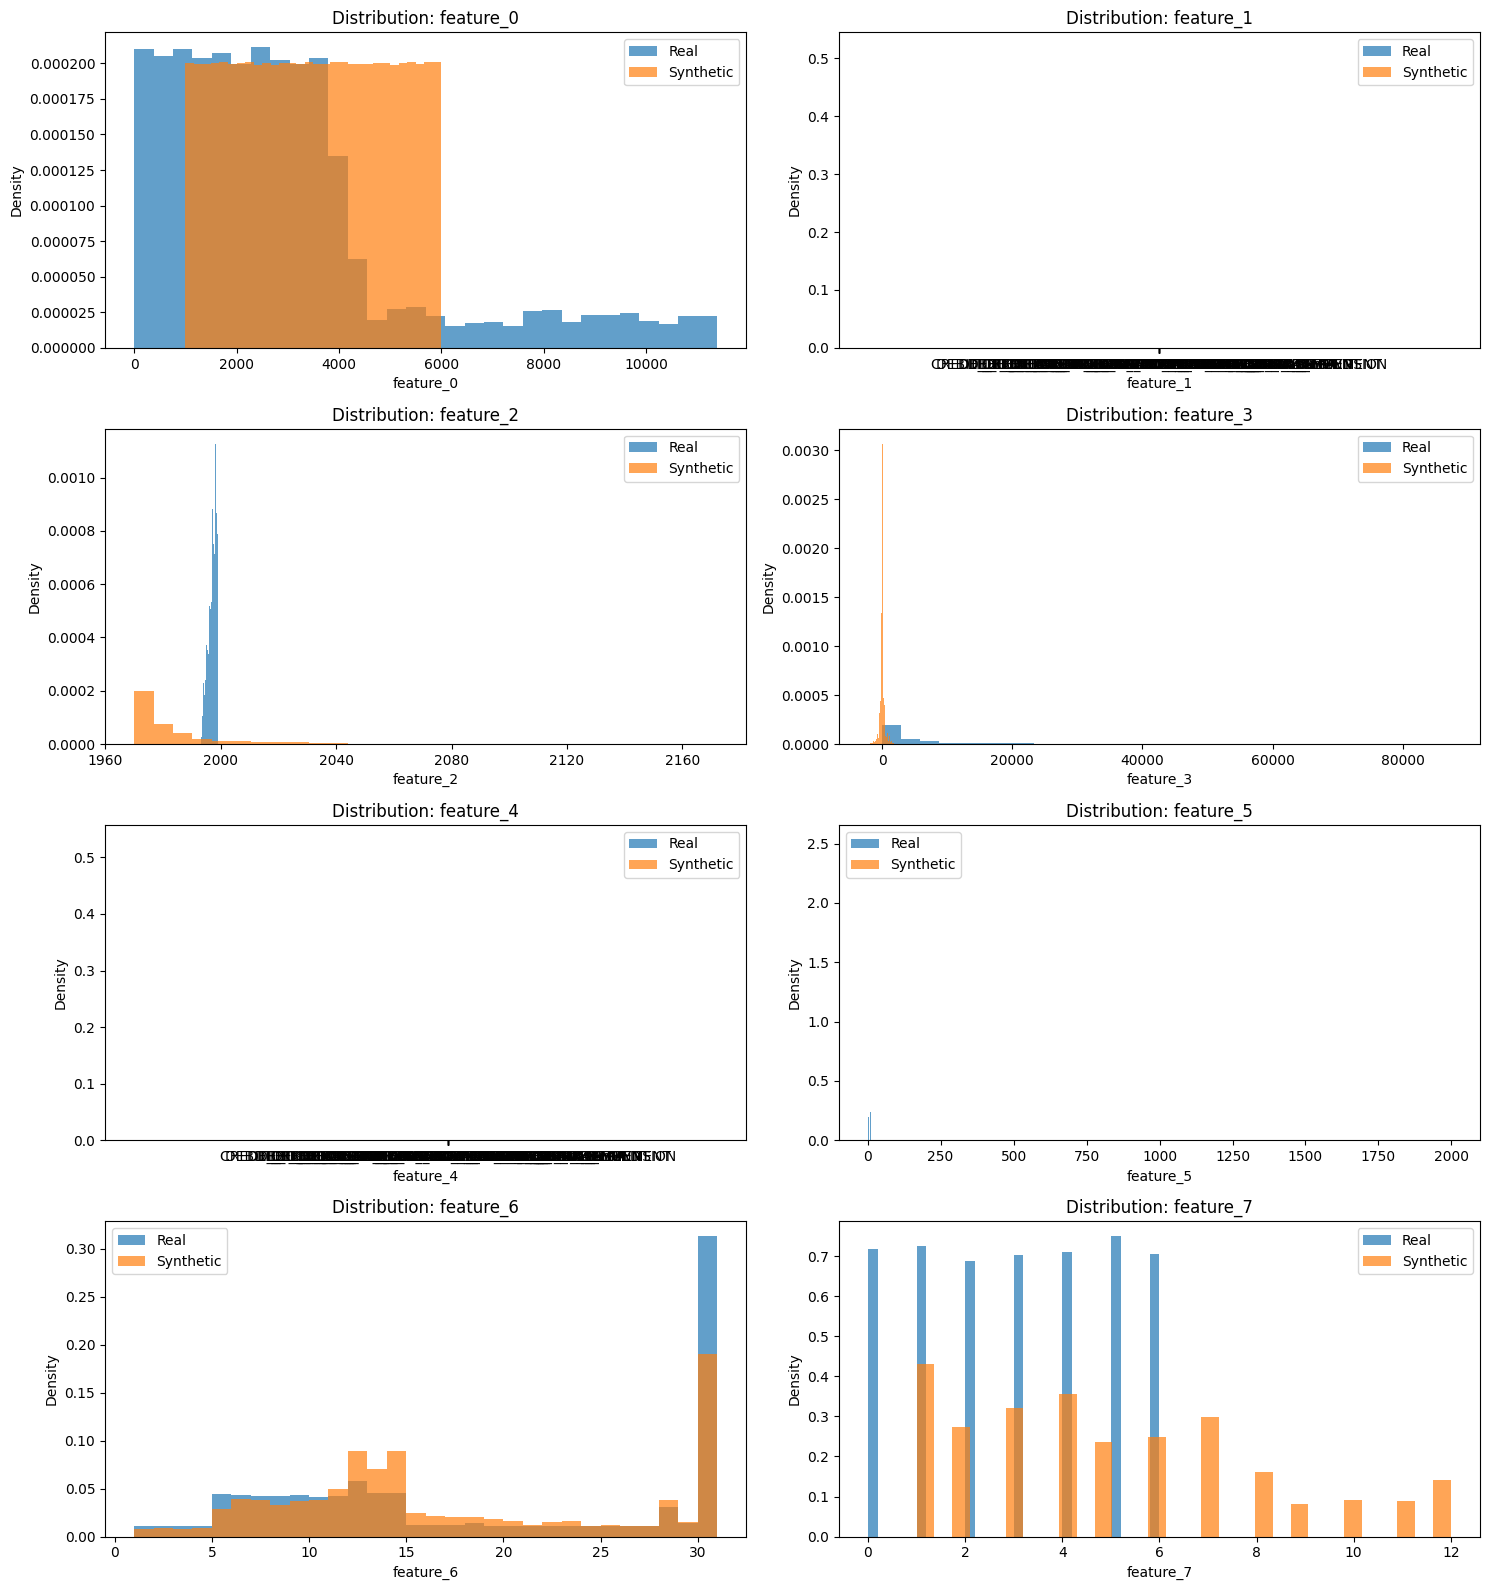

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import wasserstein_distance

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

class DataDistributionComparator:
    def __init__(self, real_data, synthetic_data):
        """
        Initialize with real and synthetic datasets

        Parameters:
        real_data: pandas DataFrame or numpy array
        synthetic_data: pandas DataFrame or numpy array
        """
        self.real_data = pd.DataFrame(real_data) if not isinstance(real_data, pd.DataFrame) else real_data
        self.synthetic_data = pd.DataFrame(synthetic_data) if not isinstance(synthetic_data, pd.DataFrame) else synthetic_data

        # Ensure same column names
        if list(self.real_data.columns) != list(self.synthetic_data.columns):
            common_cols = min(len(self.real_data.columns), len(self.synthetic_data.columns))
            self.real_data.columns = [f'feature_{i}' for i in range(common_cols)]
            self.synthetic_data.columns = [f'feature_{i}' for i in range(common_cols)]

    def statistical_summary(self):
        """Compare basic statistical summaries"""
        print("=== STATISTICAL SUMMARY COMPARISON ===")
        print("\nReal Data Summary:")
        print(self.real_data.describe())
        print("\nSynthetic Data Summary:")
        print(self.synthetic_data.describe())

        # Calculate summary differences
        real_summary = self.real_data.describe()
        synthetic_summary = self.synthetic_data.describe()

        print("\nAbsolute Differences in Statistics:")
        diff_summary = abs(real_summary - synthetic_summary)
        print(diff_summary)

        return real_summary, synthetic_summary, diff_summary

    def distribution_plots(self, max_features=8):
        """Generate distribution comparison plots"""
        n_features = min(len(self.real_data.columns), max_features)
        cols = 2
        rows = (n_features + 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows))
        axes = axes.flatten() if rows > 1 else [axes] if rows == 1 else axes

        for i, col in enumerate(self.real_data.columns[:n_features]):
            ax = axes[i]

            # Plot histograms
            ax.hist(self.real_data[col], alpha=0.7, bins=30, label='Real', density=True)
            ax.hist(self.synthetic_data[col], alpha=0.7, bins=30, label='Synthetic', density=True)
            ax.set_title(f'Distribution: {col}')
            ax.legend()
            ax.set_xlabel(col)
            ax.set_ylabel('Density')

        # Remove empty subplots
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

    def qq_plots(self, max_features=8):
        """Generate Q-Q plots for distribution comparison"""
        n_features = min(len(self.real_data.columns), max_features)
        cols = 2
        rows = (n_features + 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows))
        axes = axes.flatten() if rows > 1 else [axes] if rows == 1 else axes

        for i, col in enumerate(self.real_data.columns[:n_features]):
            ax = axes[i]

            # Q-Q plot
            stats.probplot(self.real_data[col], dist="norm", plot=None)
            real_quantiles = np.percentile(self.real_data[col], np.linspace(0, 100, 100))
            synthetic_quantiles = np.percentile(self.synthetic_data[col], np.linspace(0, 100, 100))

            ax.scatter(real_quantiles, synthetic_quantiles, alpha=0.6)
            ax.plot([min(real_quantiles), max(real_quantiles)],
                   [min(real_quantiles), max(real_quantiles)], 'r--', lw=2)
            ax.set_title(f'Q-Q Plot: {col}')
            ax.set_xlabel('Real Data Quantiles')
            ax.set_ylabel('Synthetic Data Quantiles')

        # Remove empty subplots
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

    def correlation_heatmaps(self):
        """Compare correlation matrices"""
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        # Real data correlation
        real_corr = self.real_data.corr()
        sns.heatmap(real_corr, annot=True, cmap='coolwarm', center=0, ax=axes[0])
        axes[0].set_title('Real Data Correlation Matrix')

        # Synthetic data correlation
        synthetic_corr = self.synthetic_data.corr()
        sns.heatmap(synthetic_corr, annot=True, cmap='coolwarm', center=0, ax=axes[1])
        axes[1].set_title('Synthetic Data Correlation Matrix')

        # Difference in correlations
        corr_diff = abs(real_corr - synthetic_corr)
        sns.heatmap(corr_diff, annot=True, cmap='Reds', ax=axes[2])
        axes[2].set_title('Absolute Correlation Difference')

        plt.tight_layout()
        plt.show()

        return real_corr, synthetic_corr, corr_diff

    def pca_comparison(self):
        """Compare PCA representations"""
        # Standardize data
        scaler_real = StandardScaler()
        scaler_synthetic = StandardScaler()

        real_scaled = scaler_real.fit_transform(self.real_data)
        synthetic_scaled = scaler_synthetic.fit_transform(self.synthetic_data)

        # Apply PCA
        pca = PCA(n_components=min(2, self.real_data.shape[1]))
        real_pca = pca.fit_transform(real_scaled)
        synthetic_pca = pca.transform(synthetic_scaled)

        # Plot PCA
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # 2D PCA plot
        axes[0].scatter(real_pca[:, 0], real_pca[:, 1], alpha=0.6, label='Real', s=20)
        axes[0].scatter(synthetic_pca[:, 0], synthetic_pca[:, 1], alpha=0.6, label='Synthetic', s=20)
        axes[0].set_title('PCA Comparison (2D)')
        axes[0].set_xlabel('PC1')
        axes[0].set_ylabel('PC2')
        axes[0].legend()

        # Explained variance
        pca_full = PCA()
        pca_full.fit(real_scaled)
        axes[1].plot(np.cumsum(pca_full.explained_variance_ratio_), 'b-', label='Real')

        pca_full.fit(synthetic_scaled)
        axes[1].plot(np.cumsum(pca_full.explained_variance_ratio_), 'r-', label='Synthetic')
        axes[1].set_title('Cumulative Explained Variance')
        axes[1].set_xlabel('Number of Components')
        axes[1].set_ylabel('Cumulative Explained Variance')
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    def statistical_tests(self):
        """Perform statistical tests for distribution similarity"""
        print("=== STATISTICAL TESTS ===")
        results = {}

        for col in self.real_data.columns:
            print(f"\n--- {col} ---")

            # Kolmogorov-Smirnov test
            ks_stat, ks_p = stats.ks_2samp(self.real_data[col], self.synthetic_data[col])
            print(f"KS Test: statistic={ks_stat:.4f}, p-value={ks_p:.4f}")

            # Mann-Whitney U test
            mw_stat, mw_p = stats.mannwhitneyu(self.real_data[col], self.synthetic_data[col], alternative='two-sided')
            print(f"Mann-Whitney U: statistic={mw_stat:.4f}, p-value={mw_p:.4f}")

            # Wasserstein distance
            wd = wasserstein_distance(self.real_data[col], self.synthetic_data[col])
            print(f"Wasserstein Distance: {wd:.4f}")

            # Anderson-Darling test
            try:
                ad_stat, ad_crit, ad_p = stats.anderson_ksamp([self.real_data[col], self.synthetic_data[col]])
                print(f"Anderson-Darling: statistic={ad_stat:.4f}, p-value={ad_p:.4f}")
            except:
                print("Anderson-Darling: Could not compute")

            results[col] = {
                'ks_stat': ks_stat, 'ks_p': ks_p,
                'mw_stat': mw_stat, 'mw_p': mw_p,
                'wasserstein': wd
            }

        return results

    def distribution_metrics(self):
        """Calculate various distribution similarity metrics"""
        print("\n=== DISTRIBUTION SIMILARITY METRICS ===")
        metrics = {}

        for col in self.real_data.columns:
            # Create histograms with same bins
            combined = np.concatenate([self.real_data[col], self.synthetic_data[col]])
            bins = np.histogram_bin_edges(combined, bins=30)

            real_hist, _ = np.histogram(self.real_data[col], bins=bins, density=True)
            synthetic_hist, _ = np.histogram(self.synthetic_data[col], bins=bins, density=True)

            # Earth Mover's Distance (Wasserstein)
            emd = wasserstein_distance(self.real_data[col], self.synthetic_data[col])

            # Jensen-Shannon Divergence
            def js_divergence(p, q):
                p = p + 1e-10  # Add small epsilon to avoid log(0)
                q = q + 1e-10
                m = 0.5 * (p + q)
                return 0.5 * stats.entropy(p, m) + 0.5 * stats.entropy(q, m)

            js_div = js_divergence(real_hist, synthetic_hist)

            # Histogram intersection
            hist_intersection = np.sum(np.minimum(real_hist, synthetic_hist))

            # Bhattacharyya distance
            bc_coeff = np.sum(np.sqrt(real_hist * synthetic_hist))
            bhatt_dist = -np.log(bc_coeff) if bc_coeff > 0 else float('inf')

            metrics[col] = {
                'earth_movers_distance': emd,
                'jensen_shannon_divergence': js_div,
                'histogram_intersection': hist_intersection,
                'bhattacharyya_distance': bhatt_dist
            }

            print(f"\n{col}:")
            print(f"  Earth Mover's Distance: {emd:.4f}")
            print(f"  Jensen-Shannon Divergence: {js_div:.4f}")
            print(f"  Histogram Intersection: {hist_intersection:.4f}")
            print(f"  Bhattacharyya Distance: {bhatt_dist:.4f}")

        return metrics

    def privacy_metrics(self):
        """Calculate privacy-related metrics"""
        print("\n=== PRIVACY METRICS ===")

        # Distance to Closest Record (DCR)
        from sklearn.neighbors import NearestNeighbors

        # Fit on real data, find nearest synthetic points
        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(self.real_data)
        distances, indices = nn.kneighbors(self.synthetic_data)

        dcr_mean = np.mean(distances)
        dcr_min = np.min(distances)

        print(f"Distance to Closest Record (DCR):")
        print(f"  Mean: {dcr_mean:.4f}")
        print(f"  Min: {dcr_min:.4f}")

        # Nearest Neighbor Distance Ratio (NNDR)
        nn2 = NearestNeighbors(n_neighbors=2)
        nn2.fit(self.real_data)
        distances2, _ = nn2.kneighbors(self.synthetic_data)

        nndr = distances2[:, 0] / (distances2[:, 1] + 1e-10)
        nndr_mean = np.mean(nndr)

        print(f"Nearest Neighbor Distance Ratio (NNDR): {nndr_mean:.4f}")

        return {
            'dcr_mean': dcr_mean,
            'dcr_min': dcr_min,
            'nndr_mean': nndr_mean
        }

    def comprehensive_report(self):
        """Generate a comprehensive comparison report"""
        print("=" * 60)
        print("COMPREHENSIVE DATA DISTRIBUTION COMPARISON REPORT")
        print("=" * 60)

        # Statistical summary
        real_stats, synthetic_stats, diff_stats = self.statistical_summary()

        # Plots
        print("\nGenerating distribution plots...")
        self.distribution_plots()

        print("\nGenerating Q-Q plots...")
        self.qq_plots()

        print("\nGenerating correlation heatmaps...")
        real_corr, synthetic_corr, corr_diff = self.correlation_heatmaps()

        print("\nGenerating PCA comparison...")
        self.pca_comparison()

        # Statistical tests
        test_results = self.statistical_tests()

        # Distribution metrics
        dist_metrics = self.distribution_metrics()

        # Privacy metrics
        privacy_metrics = self.privacy_metrics()

        # Overall similarity score
        print("\n=== OVERALL SIMILARITY ASSESSMENT ===")

        # Calculate average p-values from statistical tests
        avg_ks_p = np.mean([test_results[col]['ks_p'] for col in test_results])
        avg_mw_p = np.mean([test_results[col]['mw_p'] for col in test_results])
        avg_wasserstein = np.mean([test_results[col]['wasserstein'] for col in test_results])

        print(f"Average KS Test p-value: {avg_ks_p:.4f}")
        print(f"Average Mann-Whitney p-value: {avg_mw_p:.4f}")
        print(f"Average Wasserstein Distance: {avg_wasserstein:.4f}")

        # Similarity interpretation
        similarity_score = (avg_ks_p + avg_mw_p) / 2
        if similarity_score > 0.05:
            print(f"\nSIMILARITY ASSESSMENT: HIGH (p-value: {similarity_score:.4f})")
            print("The distributions are statistically similar.")
        elif similarity_score > 0.01:
            print(f"\nSIMILARITY ASSESSMENT: MODERATE (p-value: {similarity_score:.4f})")
            print("The distributions show some differences.")
        else:
            print(f"\nSIMILARITY ASSESSMENT: LOW (p-value: {similarity_score:.4f})")
            print("The distributions are significantly different.")

        return {
            'statistical_summary': (real_stats, synthetic_stats, diff_stats),
            'correlations': (real_corr, synthetic_corr, corr_diff),
            'statistical_tests': test_results,
            'distribution_metrics': dist_metrics,
            'privacy_metrics': privacy_metrics,
            'similarity_score': similarity_score
        }

# Example usage:
def example_usage():
    """Example of how to use the DataDistributionComparator"""

    # Generate example data
    np.random.seed(42)

    # Real data (multivariate normal)


    # Create DataFrames
    real_df = pd.DataFrame(real_sorted, columns=['Amount', 'raw_amount'])
    synthetic_df = pd.DataFrame(synth_sorted, columns=['Amount', 'raw_amount'])

    # Initialize comparator
    comparator = DataDistributionComparator(real_df, synthetic_df)

    # Run comprehensive comparison
    results = comparator.comprehensive_report()

    return results

# Initialize with your data
comparator = DataDistributionComparator(real_sorted, synth_sorted)

# Run individual methods
comparator.distribution_plots()
comparator.qq_plots()
comparator.correlation_heatmaps()

# Or run the comprehensive report
results = comparator.comprehensive_report()

In [ ]:
real_sorted=pd.read_csv('real_sorted.csv')
synth_sorted=pd.read_csv('synth_sorted.csv')

In [ ]:
real_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10000 non-null  object 
 1   amount      10000 non-null  float64
 2   raw_amount  10000 non-null  float64
 3   month       10000 non-null  int64  
 4   day         10000 non-null  int64  
 5   dow         10000 non-null  int64  
 6   year        10000 non-null  int64  
 7   td          10000 non-null  float64
 8   type        10000 non-null  object 
 9   dtme        10000 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 781.4+ KB


Differentially Private Mean (Real): 186.16
Mean (Synthetic): -718.11
Wasserstein distance (DP real vs synthetic): 0.0463


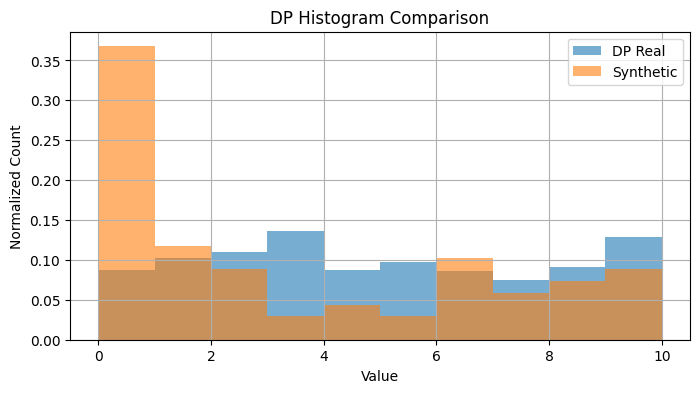

In [ ]:
# from sdmetrics.single_table import DCRBaselineProtection
# from sdv.metadata import SingleTableMetadata

# # Step 1: Detect metadata
# metadata = SingleTableMetadata()
# metadata.detect_from_dataframe(data=real_sorted)

# # ✅ Step 2: Convert to dictionary
# metadata_dict = metadata.to_dict()

# # Step 3: Compute DCR breakdown
# score = DCRBaselineProtection.compute_breakdown(
#     real_data=real_sorted,
#     synthetic_data=synth_sorted,
#     metadata=metadata_dict
# )

# print(score)



import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

# -----------------------
# Parameters
# -----------------------
epsilon = 0.60  # privacy budget
sensitivity = 1.0  # assume bounded data in [0, 1] range

# -----------------------
# Generate Sample Data
# -----------------------
np.random.seed(42)
real_data = real_sorted[['raw_amount']]
synthetic_data = synth_sorted[['raw_amount']]

# -----------------------
# 1. Differentially Private Mean
# -----------------------
def dp_mean(data, epsilon, sensitivity):
    true_mean = np.mean(data)
    noise = np.random.laplace(loc=0.0, scale=sensitivity/epsilon)
    return true_mean + noise

dp_real_mean = dp_mean(real_data, epsilon, sensitivity)
synthetic_mean = np.mean(synthetic_data)

print(f"Differentially Private Mean (Real): {dp_real_mean:.2f}")
print(f"Mean (Synthetic): {synthetic_mean:.2f}")

# -----------------------
# 2. Differentially Private Histogram
# -----------------------
def dp_histogram(data, bins, epsilon):
    counts, bin_edges = np.histogram(data, bins=bins, range=(0, 10))
    dp_counts = counts + np.random.laplace(scale=1/epsilon, size=len(counts))
    dp_counts = np.clip(dp_counts, 0, None)  # remove negative counts
    return dp_counts, bin_edges

bins = 10
dp_real_hist, bin_edges = dp_histogram(real_data, bins, epsilon)
synthetic_hist, _ = np.histogram(synthetic_data, bins=bins, range=(0, 10))

# Normalize for comparison
dp_real_hist_norm = dp_real_hist / np.sum(dp_real_hist)
synthetic_hist_norm = synthetic_hist / np.sum(synthetic_hist)

# -----------------------
# 3. Compute Histogram Distance
# -----------------------
distance = wasserstein_distance(dp_real_hist_norm, synthetic_hist_norm)
print(f"Wasserstein distance (DP real vs synthetic): {distance:.4f}")

# -----------------------
# 4. Plotting
# -----------------------
plt.figure(figsize=(8, 4))
plt.bar(bin_edges[:-1], dp_real_hist_norm, width=1, alpha=0.6, label="DP Real", align='edge')
plt.bar(bin_edges[:-1], synthetic_hist_norm, width=1, alpha=0.6, label="Synthetic", align='edge')
plt.legend()
plt.title("DP Histogram Comparison")
plt.xlabel("Value")
plt.ylabel("Normalized Count")
plt.grid(True)
plt.show()


In [ ]:

# from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
# n = 1056320
# batch_size = 700
# noise_multiplier = 2.2
# epochs = 100
# delta = 1e-5
# epsilon, _ = compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=n, batch_size=batch_size,noise_multiplier=noise_multiplier,epochs=epochs,delta=delta)
# epsilon

## Evaluation

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import nltk
from nltk.util import ngrams
from scipy.special import rel_entr
from scipy.special import entr
from scipy.spatial import distance

from scipy.stats import energy_distance
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp
import random
import os

# random.seed(0)
# np.random.seed(0)
# os.environ['TF_DETERMINISTIC_OPS'] = '1'




def ks_dist(real_obs, gen_obs):
    stat, pval = ks_2samp(real_obs, gen_obs)

    return stat

def comapre_unidist_cont(CONT_FIELDS,CF_FIELD, real, synth, real_cf, synth_cf):
    """
    CONT_FIELDS : list of continuous columns
    CF_FIELD: name of the column in real_cf and synth_cf (used for computing cash flow)
    CONTINUOUS_METRICS = {"wasser": wasserstein_distance, "ks": ks_dist,"energy_d": energy_distance}
    real_cf, synth_cf: groupby(["account_id", "month", "year"]) real, and synth. and compute the sum of the raw_amount.

    """
    CONTINUOUS_METRICS = {"wasser": wasserstein_distance, "ks": ks_dist,"energy_d": energy_distance}
    univariate_cont_res = {}

    for field in CONT_FIELDS:
        univariate_cont_res[field] = {}
        for name, fn in CONTINUOUS_METRICS.items():
            univariate_cont_res[field][name] = fn(real[field], synth[field])

    univariate_cont_res['CF'] = {}
    for name, fn in CONTINUOUS_METRICS.items():
        univariate_cont_res['CF'][name] = fn(real_cf[CF_FIELD], synth_cf[CF_FIELD])
    return univariate_cont_res

def comapre_unidist_cat(real, synth, field):
    real_distribution = real[field].value_counts(normalize=True).sort_index()
    synthetic_distribution = synth[field].value_counts(normalize=True).sort_index()
    df_tcode = pd.merge(real_distribution, synthetic_distribution, left_index=True, right_index=True, how='outer')
    df_tcode.columns = ['real', 'synthetic']

    # Fill missing values with 0
    df_tcode.fillna(0, inplace=True)
    df_tcode['mid'] = (df_tcode['real'] + df_tcode['synthetic'])/2
    kl_real_M = sum(rel_entr(df_tcode['real'], df_tcode['mid']))
    kl_gen_M = sum(rel_entr(df_tcode['synthetic'], df_tcode['mid']))

    jsd = (kl_real_M + kl_gen_M)/2
    return jsd

def create_ngramcount_df(df, n, field):
    #gb = df.sort_values(by=["account_id", "datetime"]).groupby("account_id", sort=False)[field]
    gb = df.groupby("account_id", sort=False)[field]
    ngram_list = gb.apply(lambda x: list(ngrams(x, n=n)))

    counts = {}
    for ngram_seq in ngram_list:
        for ngram in ngram_seq:
            ngram = str(ngram)[1:-1]
            counts[ngram] = counts.get(ngram, 0) + 1


    df = pd.DataFrame.from_dict(counts, orient="index", columns=["counts"]).sort_values("counts", ascending=False)


    return df.reset_index().rename(columns={"index": "ngram"})

def compute_ngram_metrics(real_df, gen_df, field, n , pseudo_counts=0.0):


    n_codes_unique = len(set(real_df[field].unique()).union(set(gen_df[field].unique())))


    # create combo_df, which contains counts of all ngrams for both datasets (note: it omits any ngrams which do not occur in either dataset)
    real_ngrams = create_ngramcount_df(real_df, n, field)
    gen_ngrams = create_ngramcount_df(gen_df, n, field)
    combo_df = pd.merge(real_ngrams, gen_ngrams, on="ngram", how="outer", suffixes=("_real", "_gen")).fillna(0.0)


    N_obs_real = real_ngrams["counts"].sum()
    N_obs_gen = gen_ngrams["counts"].sum()
    N_possible_ngrams = n_codes_unique**n


    # add psudo-counts
    combo_df["counts_real"] += pseudo_counts
    combo_df["ps_real"] = combo_df["counts_real"] / (N_obs_real + N_possible_ngrams*pseudo_counts)
    combo_df["counts_gen"] += pseudo_counts
    combo_df["ps_gen"] = combo_df["counts_gen"] / (N_obs_gen + N_possible_ngrams*pseudo_counts)




    # compute jsd (note: contribution to jsd from any ngram not in either dataset is 0)
    combo_df["ps_mid"] = (combo_df["ps_real"] + combo_df["ps_gen"])/2
    kl_real_M = sum(rel_entr(combo_df["ps_real"], combo_df["ps_mid"]))
    kl_gen_M = sum(rel_entr(combo_df["ps_gen"], combo_df["ps_mid"]))

    jsd = (kl_real_M + kl_gen_M)/2


    # compute entropy for both distributions
    n_unobs = N_possible_ngrams - len(combo_df)

    entr_r = entr(combo_df["ps_real"]).sum()  # from observed

    entr_g = entr(combo_df["ps_gen"]).sum()  # from observed

    results = {"jsd":jsd,
                      "entr_r":entr_r,
                      "entr_g":entr_g,
                      "NED": entr_r - entr_g,
                      "l1":distance.minkowski(combo_df["ps_real"], combo_df["ps_gen"], p=1),
                      "l2":distance.minkowski(combo_df["ps_real"], combo_df["ps_gen"], p=2),
                      "jac": distance.jaccard(combo_df["counts_real"]>0, combo_df["counts_gen"] > 0),
                      "count_r": len(real_ngrams),
                      "coverage_r": len(real_ngrams)/N_possible_ngrams,
                      "count_g": len(gen_ngrams),
                      "coverage_g": len(gen_ngrams)/N_possible_ngrams,
                      "count_max": N_possible_ngrams,
                      "field": field,
                       "n":n,
                       "pseudo_counts":pseudo_counts}

    return combo_df, results

#joint distribution of two categorical columns
def compute_2d_categorical_metrics(real_df, gen_df, field1, field2):
    f1_opts = set(real_df[field1].unique()).union(set(gen_df[field1].unique()))
    f2_opts = set(real_df[field2].unique()).union(set(gen_df[field2].unique()))

    n_opts_total = len(f1_opts) * len(f2_opts)

    kl_r_m = 0.
    kl_g_m = 0.
    entr_r = 0.
    entr_g = 0.
    l1_d = 0.
    l2_d = 0.
    count_g = 0.
    count_r = 0.

    observed_opts = 0

    cont_metric_results = {}
    for code_1 in f1_opts:
        for code_2 in f2_opts:
            cond_r = np.logical_and(real_df[field1] == code_1, real_df[field2] == code_2)
            cond_g = np.logical_and(gen_df[field1] == code_1, gen_df[field2] == code_2)

            p_r = (np.sum(cond_r)) / (len(cond_r))
            p_g = (np.sum(cond_g)) / (len(cond_g))
            p_m = (p_r + p_g) / 2.

            if np.sum(cond_r) + np.sum(cond_g) > 0:
                observed_opts += 1


            count_r += int(np.sum(cond_r) > 0)
            count_g += int(np.sum(cond_g) > 0)

            l1_d += np.abs(p_r - p_g)
            l2_d += (p_r - p_g) ** 2


            if p_r > 0:
                kl_r_m += p_r * np.log(p_r / p_m)
                entr_r += - p_r * np.log(p_r)

            if p_g > 0:
                kl_g_m += p_g * np.log(p_g / p_m)
                entr_g += - p_g * np.log(p_g)

    # compute jaccard
    sr = set(zip(real_df[field1].to_list(), real_df[field2].to_list()))
    sg = set(zip(gen_df[field1].to_list(), gen_df[field2].to_list()))
    s_union = len(sr.union(sg))
    s_inter = len(sr.intersection(sg))
    jacc_d = (s_union - s_inter) / s_union

    # finshed l2
    l2_d = np.sqrt(l2_d)

    # coverage
    coverage_g = count_g / n_opts_total
    coverage_r = count_r / n_opts_total

    #jsd
    jsd = (kl_r_m + kl_g_m) / 2


    result = {'jsd': jsd,
                    'entr_r': entr_r,
                    'entr_g': entr_g,
                    'l1': l1_d,
                    'l2': l2_d,
                    'jac': jacc_d,
                    'count_r': count_r,
                    'coverage_r': coverage_r,
                    'count_g': count_g,
                    'coverage_g': coverage_g,
                    'count_max': n_opts_total}
    return result



In [ ]:
combo_df, result = compute_ngram_metrics(real_sorted, synth_sorted, 'tcode', 3)
result



{'jsd': 0.17490200518226243,
 'entr_r': np.float64(5.425261658301508),
 'entr_g': np.float64(6.142695062410825),
 'NED': np.float64(-0.7174334041093164),
 'l1': np.float64(0.9028012838710908),
 'l2': 0.075932281597543,
 'jac': np.float64(0.5581395348837209),
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 2785,
 'coverage_g': 0.679931640625,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}

In [ ]:
CAT_FIELDS = ['tcode']
result_jst_cat = {}
for field in CAT_FIELDS:
    result_jst_cat[field] = comapre_unidist_cat(real_sorted, synth_sorted, field)
result_jst_cat

{'tcode': 0.011267004803634382}

In [ ]:
CONT_FIELDS = ["amount", "td"]

CF_FIELD = 'raw_amount'

#compare univariate distribution of continuous columns
comapre_unidist_cont(CONT_FIELDS,CF_FIELD, real_sorted, synth_sorted, real_cf, synth_cf)

{'amount': {'wasser': np.float64(465.6911637870963),
  'ks': np.float64(0.14004276415229924),
  'energy_d': np.float64(5.5119527875386)},
 'td': {'wasser': np.float64(200.92419701414164),
  'ks': np.float64(0.44336293409934724),
  'energy_d': np.float64(7.804267391161782)},
 'CF': {'wasser': np.float64(6238.542111239304),
  'ks': np.float64(0.2346297670961271),
  'energy_d': np.float64(32.588742915210936)}}

In [ ]:
# JSD result comparing the univariate distributions of the tcode (Tcode), and DOM
CAT_FIELDS = ['tcode', 'day', 'month']
result_jst_cat = {}
for field in CAT_FIELDS:
    result_jst_cat[field] = comapre_unidist_cat(real, synth_sorted, field)
result_jst_cat

{'tcode': 0.011267004803634382,
 'day': 0.020213444317475265,
 'month': 0.03503929365982579}

In [ ]:
CONT_FIELDS = ["amount", "td"]

CF_FIELD = 'raw_amount'

#compare univariate distribution of continuous columns
comapre_unidist_cont(CONT_FIELDS,CF_FIELD, real, synth_sorted, real_cf, synth_cf)

{'amount': {'wasser': np.float64(465.6911637870963),
  'ks': np.float64(0.14004276415229924),
  'energy_d': np.float64(5.5119527875386)},
 'td': {'wasser': np.float64(200.92419701414164),
  'ks': np.float64(0.44336293409934724),
  'energy_d': np.float64(7.804267391161782)},
 'CF': {'wasser': np.float64(6238.542111239304),
  'ks': np.float64(0.2346297670961271),
  'energy_d': np.float64(32.588742915210936)}}

In [ ]:
field1='tcode'
field2='day'

compute_2d_categorical_metrics(real_sorted, synth_sorted, field1, field2)

{'jsd': np.float64(0.06518080462623126),
 'entr_r': np.float64(4.314351501994387),
 'entr_g': np.float64(4.7887207825365365),
 'l1': np.float64(0.5128064928681239),
 'l2': np.float64(0.08879960989423331),
 'jac': 0.5161290322580645,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 496.0,
 'coverage_g': 1.0,
 'count_max': 496}

In [ ]:
# build a metadata for evaluation (from SDV)
metadata= SingleTableMetadata()
metadata.detect_from_dataframe(data=real)

#generate quality report
quality_report= sdv_st.evaluate_quality(
    real_data=real,
    synthetic_data=synth_sorted,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 12/12 [00:02<00:00,  4.38it/s]|
Column Shapes Score: 80.6%

(2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:05<00:00, 11.50it/s]|
Column Pair Trends Score: 74.83%

Overall Score (Average): 77.72%



In [ ]:
# using quantiletransfromation

# {'jsd': 0.20895610685531635,
#  'entr_r': np.float64(5.425261658301508),
#  'entr_g': np.float64(6.470970665757771),
#  'NED': np.float64(-1.0457090074562627),
#  'l1': np.float64(1.0024058377229252),
#  'l2': 0.08006365467671196,
#  'jac': np.float64(0.5559477585598306),
#  'count_r': 1431,
#  'coverage_r': 0.349365234375,
#  'count_g': 2660,
#  'coverage_g': 0.6494140625,
#  'count_max': 4096,
#  'field': 'tcode',
#  'n': 3,
#  'pseudo_counts': 0.0}


#  {'tcode': 0.02774456991668183}


#  {'amount': {'wasser': np.float64(968.410722896976),
#   'ks': np.float64(0.1406286340572203),
#   'energy_d': np.float64(7.448278441147479)},
#  'td': {'wasser': np.float64(126.02985964069423),
#   'ks': np.float64(0.4282113009306922),
#   'energy_d': np.float64(5.70706700837831)},
#  'CF': {'wasser': np.float64(5247.605577433625),
#   'ks': np.float64(0.18768472068778763),
#   'energy_d': np.float64(26.143051713848166)}}


#   {'jsd': np.float64(0.06410917108699209),
#  'entr_r': np.float64(4.314351501994385),
#  'entr_g': np.float64(4.740457509293517),
#  'l1': np.float64(0.5334007575827873),
#  'l2': np.float64(0.10117351080460896),
#  'jac': 0.5370370370370371,
#  'count_r': 240.0,
#  'coverage_r': 0.4838709677419355,
#  'count_g': 471.0,
#  'coverage_g': 0.9495967741935484,
#  'count_max': 496}


# (1/2) Evaluating Column Shapes: |██████████| 12/12 [00:01<00:00,  6.61it/s]|
# Column Shapes Score: 84.3%

# (2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:05<00:00, 11.72it/s]|
# Column Pair Trends Score: 78.71%

# Overall Score (Average): 81.51%


#################### minmax scaler

# {'jsd': 0.21269415540111195,
#  'entr_r': np.float64(5.425261658301508),
#  'entr_g': np.float64(6.44288578106312),
#  'NED': np.float64(-1.017624122761612),
#  'l1': np.float64(1.012126580932822),
#  'l2': 0.08190782959868136,
#  'jac': np.float64(0.5562655307064253),
#  'count_r': 1431,
#  'coverage_r': 0.349365234375,
#  'count_g': 2636,
#  'coverage_g': 0.6435546875,
#  'count_max': 4096,
#  'field': 'tcode',
#  'n': 3,
#  'pseudo_counts': 0.0}


#  {'tcode': 0.029975206665479072}



#  {'amount': {'wasser': np.float64(4097.36361365561),
#   'ks': np.float64(0.2365480164483358),
#   'energy_d': np.float64(34.153042649603826)},
#  'td': {'wasser': np.float64(139.95484090662794),
#   'ks': np.float64(0.4323053983355605),
#   'energy_d': np.float64(6.067448603527627)},
#  'CF': {'wasser': np.float64(9090.25328216198),
#   'ks': np.float64(0.20473236614961454),
#   'energy_d': np.float64(45.5045052306492)}}



# {'tcode': 0.029975206665479072,
#  'day': 0.030672299940901253,
#  'month': 0.03590046651411827}

#   {'jsd': np.float64(0.06361582421202078),
#  'entr_r': np.float64(4.31435150199439),
#  'entr_g': np.float64(4.77432743272917),
#  'l1': np.float64(0.546367792278892),
#  'l2': np.float64(0.10059388366937012),
#  'jac': 0.5185185185185185,
#  'count_r': 240.0,
#  'coverage_r': 0.4838709677419355,
#  'count_g': 480.0,
#  'coverage_g': 0.967741935483871,
#  'count_max': 496}



# standardization scaler

# {'jsd': 0.21871622040355754,
#  'entr_r': np.float64(5.425261658301508),
#  'entr_g': np.float64(6.317139108886275),
#  'NED': np.float64(-0.8918774505847669),
#  'l1': np.float64(1.0246080237771358),
#  'l2': 0.08424213105580201,
#  'jac': np.float64(0.5533667621776505),
#  'count_r': 1431,
#  'coverage_r': 0.349365234375,
#  'count_g': 2608,
#  'coverage_g': 0.63671875,
#  'count_max': 4096,
#  'field': 'tcode',
#  'n': 3,
#  'pseudo_counts': 0.0}

#  {'tcode': 0.03550033279814385}

# {'amount': {'wasser': np.float64(1184.0571711537327),
#   'ks': np.float64(0.21740345837695266),
#   'energy_d': np.float64(13.36110780205315)},
#  'td': {'wasser': np.float64(125.61508986666297),
#   'ks': np.float64(0.43121447374176897),
#   'energy_d': np.float64(5.623829249655311)},
#  'CF': {'wasser': np.float64(7352.945519113788),
#   'ks': np.float64(0.159792953599026),
#   'energy_d': np.float64(31.66205270212965)}}

# {'tcode': 0.03550033279814385,
#  'day': 0.03472186205573735,
#  'month': 0.03969638143057709}


#  {'jsd': np.float64(0.06919931250185361),
#  'entr_r': np.float64(4.3143515019943885),
#  'entr_g': np.float64(4.794699466984028),
#  'l1': np.float64(0.572270769850239),
#  'l2': np.float64(0.10733262603391942),
#  'jac': 0.5175983436853002,
#  'count_r': 240.0,
#  'coverage_r': 0.4838709677419355,
#  'count_g': 476.0,
#  'coverage_g': 0.9596774193548387,
#  'count_max': 496}


# (1/2) Evaluating Column Shapes: |██████████| 12/12 [00:01<00:00,  6.77it/s]|
# Column Shapes Score: 82.46%

# (2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:06<00:00, 10.51it/s]|
# Column Pair Trends Score: 73.36%

# Overall Score (Average): 77.91%


###################
# robust scaler

{'jsd': 0.2238249506595363,
#  'entr_r': np.float64(5.425261658301508),
#  'entr_g': np.float64(6.468087022035875),
#  'NED': np.float64(-1.0428253637343667),
#  'l1': np.float64(1.038884341292078),
#  'l2': 0.08316677979969443,
#  'jac': np.float64(0.5601659751037344),
#  'count_r': 1431,
#  'coverage_r': 0.349365234375,
#  'count_g': 2733,
#  'coverage_g': 0.667236328125,
#  'count_max': 4096,
#  'field': 'tcode',
#  'n': 3,
#  'pseudo_counts': 0.0}


#  {'tcode': 0.03769884734572386}

# {'amount': {'wasser': np.float64(1436.3370398134352),
#   'ks': np.float64(0.1892155429517546),
#   'energy_d': np.float64(11.810592396524745)},
#  'td': {'wasser': np.float64(129.2260706775895),
#   'ks': np.float64(0.43184739122323335),
#   'energy_d': np.float64(5.6902182153727505)},
#  'CF': {'wasser': np.float64(4811.216476938086),
#   'ks': np.float64(0.17638743125450845),
#   'energy_d': np.float64(24.666484804077665)}}


# {'tcode': 0.03769884734572386,
#  'day': 0.03578081122324883,
#  'month': 0.021950881272659734}

# {'jsd': np.float64(0.07257442453923015),
#  'entr_r': np.float64(4.3143515019943885),
#  'entr_g': np.float64(4.8320032657329275),
#  'l1': np.float64(0.5807335189265228),
#  'l2': np.float64(0.10958341305469754),
#  'jac': 0.5192697768762677,
#  'count_r': 240.0,
#  'coverage_r': 0.4838709677419355,
#  'count_g': 490.0,
#  'coverage_g': 0.9879032258064516,
#  'count_max': 496}


#  (1/2) Evaluating Column Shapes: |██████████| 12/12 [00:01<00:00,  6.55it/s]|
# Column Shapes Score: 83.69%

# (2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:05<00:00, 11.36it/s]|
# Column Pair Trends Score: 74.05%

# Overall Score (Average): 78.87%


 # yeo johnson---Power Transformation

#  {'jsd': 0.21399510082575945,
#  'entr_r': np.float64(5.425261658301508),
#  'entr_g': np.float64(6.33399198903269),
#  'NED': np.float64(-0.9087303307311814),
#  'l1': np.float64(1.0138228453311977),
#  'l2': 0.08342103237472027,
#  'jac': np.float64(0.5546428571428571),
#  'count_r': 1431,
#  'coverage_r': 0.349365234375,
#  'count_g': 2616,
#  'coverage_g': 0.638671875,
#  'count_max': 4096,
#  'field': 'tcode',
#  'n': 3,
#  'pseudo_counts': 0.0}


#  {'tcode': 0.03226479543497485}

# {'amount': {'wasser': np.float64(11854.191423262853),
#   'ks': np.float64(0.18017404641228188),
#   'energy_d': np.float64(8.686935581859142)},
#  'td': {'wasser': np.float64(128.10299283870805),
#   'ks': np.float64(0.4295799031539563),
#   'energy_d': np.float64(5.6317152086646765)},
#  'CF': {'wasser': np.float64(50156.51252091241),
#   'ks': np.float64(0.14878956069441968),
#   'energy_d': np.float64(32.322595025021315)}}



#   {'tcode': 0.03226479543497485,
#  'day': 0.03153657041535282,
#  'month': 0.038630186702060185}



#  {'jsd': np.float64(0.06685884116011785),
#  'entr_r': np.float64(4.3143515019943885),
#  'entr_g': np.float64(4.801256970808941),
#  'l1': np.float64(0.5576092485901796),
#  'l2': np.float64(0.10263866578122155),
#  'jac': 0.5133470225872689,
#  'count_r': 240.0,
#  'coverage_r': 0.4838709677419355,
#  'count_g': 484.0,
#  'coverage_g': 0.9758064516129032,
#  'count_max': 496}


#  (1/2) Evaluating Column Shapes: |██████████| 12/12 [00:01<00:00,  6.59it/s]|
# Column Shapes Score: 83.53%

# (2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:06<00:00, 10.74it/s]|
# Column Pair Trends Score: 72.97%

# Overall Score (Average): 78.25%

In [ ]:
fig = quality_report.get_visualization(property_name='Column Shapes')
fig.show()